## B. Petek, D. Nabergoj, E. Štrumbelj: A General Approach to Visualizing Uncertainty in Statistical Graphics

This Jupyter notebook contains examples of using the $bootplot$ library (https://github.com/davidnabergoj/bootplot) to generate statistical graphics with visualized uncertainty. The resulting images are featured in our paper A General Approach to Visualizing Uncertainty in Statistical Graphics.

To run this notebook, make sure that the datasets $penguins.csv$ and $trajectories.csv$ and images $map.jpg$, $X-adelie.png$ and $adelie.png$ are present in the working directory. All files are available in our GitHub repository.

First, we install the required libraries. Note that we use the "cairo" Matplotlib backend due to a known antialiasing issue affecting some backends. While $bootplot$ can be used without antialiasing if the DPI is sufficiently high, we enable antialiasing here to avoid the issue altogether.

In [1]:
# Computing
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from scipy.stats import gaussian_kde

# Plotting
import matplotlib
matplotlib.use("cairo")
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bootplot import bootplot
from bootplot.backend.matplotlib import plot_to_array, close_figure
from pywaffle import Waffle
from pysankey2 import Sankey
import networkx as nx
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle


# Image processing
import matplotlib.image as mpimg
import cv2
from PIL import Image

# Display tools
from IPython.display import display
#!pip install --upgrade bootplot

Next, we define a helper function to save and display images side by side, allowing for easy visual comparison.

In [2]:
# Combine and show two images one next to each other.
def show_images(image_paths, output_path="", above=False):
    if len(image_paths) > 1:
        images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
        above = 0 if above else 1
        combined = np.concatenate(images, axis=above)
        Image.fromarray(combined).save(output_path)
    else:
        output_path=image_paths[0]
    with Image.open(output_path) as img:
        display(img)

Several image parameters, such as dots per inch (DPI) and font sizes, remain constant across examples. We define these as global settings for convenience.

Since the bootplot library operates directly on pixels, the output image dimensions must be specified in pixels. The relationship between inches and pixels is given by:

$$\text{pixels} = \text{DPI} \times \text{inches}$$

For example, the default bootplot output is $512×512$ pixels, which corresponds to a $5.12×5.12$ inch image when the DPI is set to $100$.

In [3]:
dpi = 300
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 12

We use the Palmer Penguins dataset, which includes both categorical and numerical variables. The dataset was accessed on November 11, 2024, from https://github.com/allisonhorst/palmerpenguins.

Below, we load and prepare the dataset as a pandas DataFrame. Note that $bootplot$ also accepts input in the form of NumPy arrays.

In [4]:
# Read the csv file and create pandas dataframe
csv_file_path = 'penguins.csv'
df = pd.read_csv(csv_file_path)
penguins = df.dropna()
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0       Adelie  Torgersen            39.1           18.7              181.0   
1       Adelie  Torgersen            39.5           17.4              186.0   
2       Adelie  Torgersen            40.3           18.0              195.0   
4       Adelie  Torgersen            36.7           19.3              193.0   
5       Adelie  Torgersen            39.3           20.6              190.0   
..         ...        ...             ...            ...                ...   
339  Chinstrap      Dream            55.8           19.8              207.0   
340  Chinstrap      Dream            43.5           18.1              202.0   
341  Chinstrap      Dream            49.6           18.2              193.0   
342  Chinstrap      Dream            50.8           19.0              210.0   
343  Chinstrap      Dream            50.2           18.7              198.0   

     body_mass_g     sex  year  
0         3750.0    male  2007  
1         3800.0  female  2007  
2         3250.0  female  2007  
4         3450.0  female  2007  
5         3650.0    male  2007  
..           ...     ...   ...  
339       4000.0    male  2009  
340       3400.0  female  2009  
341       3775.0    male  2009  
342       4100.0    male  2009  
343       3775.0  female  2009  

[333 rows x 8 columns]

In [5]:
penguins_bill_length = penguins[['species', 'bill_length_mm']]
penguins_bill_length_depth = penguins[['species','bill_length_mm', 'bill_depth_mm']].values

One of the most common parameters of interest is a point estimate. In this example, we focus on the mean bill length for each penguin species.

To visualize uncertainty using $bootplot$, we simply define a function that calculates and plots the mean bill length per species.

In [6]:
def mean_estimate(data_subset, data_full, ax):
        colors = dict(zip(['Adelie', 'Chinstrap', 'Gentoo'], ['#FF8C00', '#A020F0', '#008B8B']))
        means = data_subset.groupby('species')['bill_length_mm'].mean().reindex(colors)
        for i, (species, mean) in enumerate(means.items()):
            if pd.notna(mean):
                ax.scatter(mean, i, s=10, c=colors[species], antialiased=False,marker='s',zorder=10)
        ax.set(
            xlim=(33, 55), xticks=np.arange(33, 58, 5), xlabel='Bill Length',
            ylim=(-0.5, 2.5), yticks=[0, 1, 2], ylabel=''
        )
        ax.set_yticklabels(['Adelie', 'Chinstrap', 'Gentoo'], ha='right')
        
        ax.grid(axis='both', linewidth=0.5, color='#E8E8E8', zorder=-50)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.get_figure().set_constrained_layout(True)

In [7]:
mat = bootplot(mean_estimate,
        penguins_bill_length,
        m=39,
        output_image_path=f'mean_estimate_95.png',
        output_size_px = (dpi*3, dpi*1.5),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:00<00:00, 44.11it/s]


> Saving bootstrapped image to mean_estimate_95.png


When visualizing point estimates, variation occurs along a single dimension. In the paper, we theoretically show that in this case, the number of samples determines the expected coverage, following the formula:
$$\text{coverage} = \frac{n - 1}{n + 1}$$


For $n = 39$, as chosen in this example, the expected coverage is approximately $95\%$. To complement this theoretical result, we also examine it empirically by comparing our bootplot visualization to Seaborn’s built-in $95\%$ confidence intervals.

In [8]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=dpi, layout="constrained")

species_order = ['Adelie', 'Chinstrap', 'Gentoo']
palette = dict(zip(species_order, ['#FF8C00', '#A020F0', '#008B8B']))

sns.pointplot(
    data=penguins_bill_length,
    y='species',
    x='bill_length_mm',
    hue='species',
    estimator=np.mean,
    order=species_order,
    hue_order=species_order,
    palette=palette,
    errorbar=('ci', 95),
    n_boot=5000,
    err_kws={'linewidth': 4},
    linestyle='none',
    markers='',
    dodge=False,
    capsize=0, 
    seed=15
)

ax.set(
    xlim=(33, 55), xticks=np.arange(33, 58, 5), xlabel='Bill Length',
    ylim=(-0.5, 2.5), yticks=[0, 1, 2], ylabel=''
)
ax.set_yticklabels(['Adelie', 'Chinstrap', 'Gentoo'], ha='right')
    
ax.grid(axis='both', linewidth=0.5, color='#E8E8E8', zorder=-50)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'sns_mean_estimate_95.png', format='png')
plt.close()

As shown in the comparison below, the confidence intervals produced by $bootplot$ closely align with those generated by Seaborn. Both exhibit similar boundaries, while $bootplot$ additionally integrates a gradient that conveys the density of the uncertainty distribution.

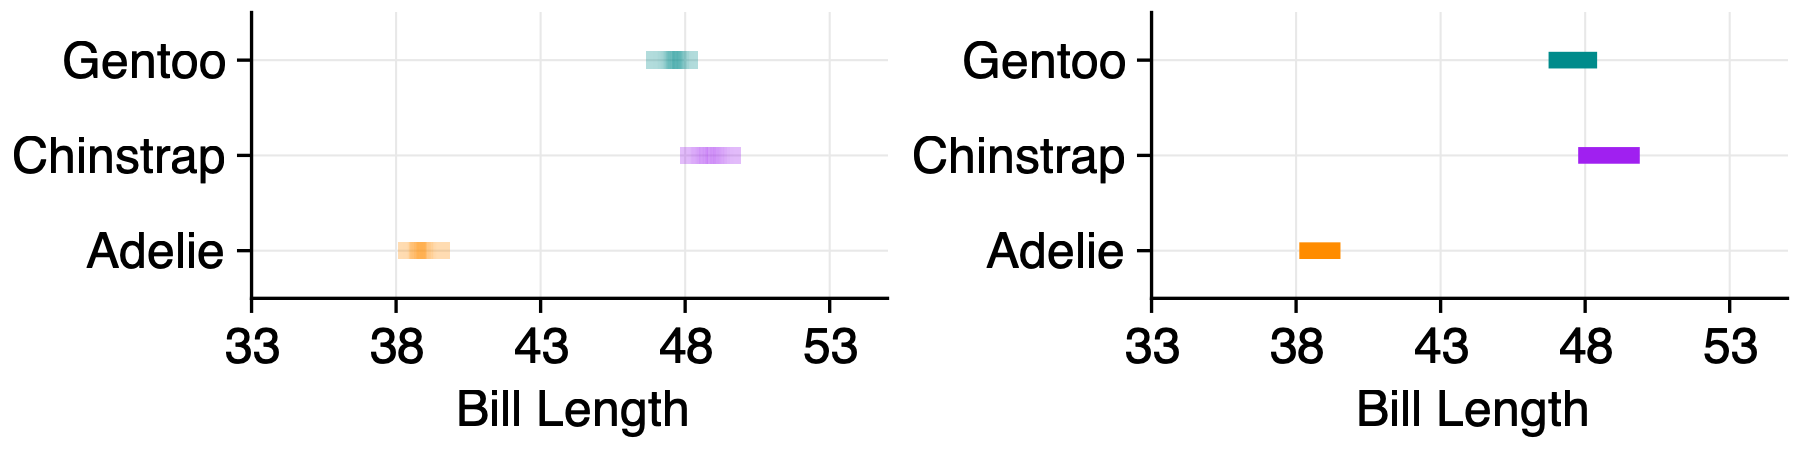

In [9]:
show_images([f'mean_estimate_95.png', f'sns_mean_estimate_95.png'], f'mean_estimate_95_comparison.png')

Another common use case arises when the parameter of interest is a function:

$$f : \mathbb{R} \rightarrow \mathbb{R}$$

Examples include various types of regression lines, such as linear or polynomial regression. In this example, we examine the relationship between bill length and bill depth across all penguin species. To visualize uncertainty with bootplot, we simply fit and plot both a linear and a polynomial regression.

In [10]:
mono_font = font_manager.FontProperties(fname='/System/Library/Fonts/SFNSMono.ttf', size=15)
colors = ['#FF8C00', '#A020F0', '#008B8B']
order=0
deg=4
ci=95
def lr_poly_line(data_subset, data_full, ax, order=0):
    ax.grid(True, linewidth=0.5, color='#E8E8E8', zorder=-100)
    ax.set_axisbelow(True)
    for i, species in enumerate(np.unique(data_full[:, 0])):
        subset = data_full[data_full[:, 0] == species]
        ax.scatter(subset[:, 1], subset[:, 2], c=colors[i], s=20, alpha=0.5,
                   edgecolor='grey', linewidths=0.75, marker='o', label=species, zorder=100)

    x_min, x_max = data_full[:, 1].min(), data_full[:, 1].max()
    y_min, y_max = data_full[:, 2].min(), data_full[:, 2].max()
    
    def plot_model(x, y, model, transform=None, color='red', lw=1, z=50, annotate_rmse=False, rmse_pos='left'):
        x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1)
        X_train = transform(x) if transform else x
        X_plot = transform(x_range) if transform else x_range
        model.fit(X_train, y)
        ax.plot(x_range.ravel(), model.predict(X_plot), c=color, lw=lw, antialiased=False, zorder=z)
        if annotate_rmse:
            rmse = np.sqrt(np.mean((y - model.predict(X_train)) ** 2))
            ax.text(
                x=x_min + 0.7 if rmse_pos == 'left' else x_max - 8,
                y=(2 * y_max - 1) / 2,
                s=f'RMSE: {rmse:.2f}',
                fontsize=8,
                ha='left', va='top',
                color='#c44e52' if rmse_pos == 'left' else '#264d73',
                fontproperties=mono_font,
                bbox=dict(facecolor='white', edgecolor='#E8E8E8',
                          boxstyle='round,pad=0.2', linewidth=0.3, alpha=1),
                zorder=1000
            )
    
    plot_model(data_subset[:, 1:2], data_subset[:, 2], LinearRegression(),
               color='#c44e52', lw=1, z=order % 4 + 500, annotate_rmse=True, rmse_pos='left')

    plot_model(data_full[:, 1:2], data_full[:, 2], LinearRegression(),
               color='#c44e52', lw=1, z=(order + 1) % 4 + 500)

    poly = PolynomialFeatures(degree=deg, include_bias=False).fit(data_subset[:, 1:2])
    plot_model(data_subset[:, 1:2], data_subset[:, 2], LinearRegression(),
               transform=poly.transform, color='#264d73', lw=1,
               z=(order + 2) % 4 + 500, annotate_rmse=True, rmse_pos='right')

    poly_full = PolynomialFeatures(degree=deg, include_bias=False).fit(data_full[:, 1:2])
    plot_model(data_full[:, 1:2], data_full[:, 2], LinearRegression(),
               transform=poly_full.transform, color='#264d73', lw=1, z=(order + 3) % 4 + 500)

    
    ax.set(xlabel='Bill Length', ylabel='Bill Depth',
           xlim=(x_min, x_max), ylim=(y_min, y_max),
           xticks=np.arange(np.ceil(x_min), np.floor(x_max) + 1, 5),
           yticks=np.arange(np.ceil(y_min), np.floor(y_max) + 1, 2))
    ax.get_figure().set_constrained_layout(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    

In [11]:
mat = bootplot(
        lr_poly_line,
        penguins_bill_length_depth,
        m=39,
        output_image_path=f'lr_pr_ci_95.png',
        output_size_px = (dpi*3, dpi*2.5),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 23.72it/s]


> Saving bootstrapped image to lr_pr_ci_95.png


When visualizing functions

$$f: \mathbb{R} \rightarrow \mathbb{R}$$


we obtain a set of points where each point varies in one dimension, and the entire set varies along the same dimension. In the paper, we theoretically show that in this case, the number of samples determines the expected point-wise coverage, following the formula:

$$\text{coverage} = \frac{n - 1}{n + 1}$$

For $n = 39$, as used in the regression example, the expected point-wise coverage is approximately $95\%$. To complement the theoretical result, we also examine it empirically by comparing bootplot visualizations to Seaborn’s $95\%$ point-wise confidence intervals.

In [12]:
fig, ax = plt.subplots(figsize=(3,2.5), dpi=dpi, layout="constrained")
ax.grid(True, linewidth=0.5, color='#E8E8E8', zorder=-100)
ax.set_axisbelow(True)


for i, species in enumerate(np.unique(penguins_bill_length_depth[:, 0])):
    subset = penguins_bill_length_depth[penguins_bill_length_depth[:, 0] == species]
    ax.scatter(subset[:, 1], subset[:, 2], c=colors[i], alpha=0.5, linewidths=0.75, s=20, edgecolor='grey',
               zorder=100, marker='o')


X = penguins_bill_length_depth[:, 1].astype(float).reshape(-1, 1)
y = penguins_bill_length_depth[:, 2].astype(float)

   
def add_rmse(model, Xp, label, x_pos):
    rmse = np.sqrt(np.mean((y - model.predict(Xp)) ** 2))
    ax.text(x_pos, (2 * y.max() - 1) / 2, f'RMSE: {rmse:.2f}', fontsize=8, ha='left', va='top', color=label,
            fontproperties=mono_font, bbox=dict(facecolor='white', edgecolor='#E8E8E8',
            boxstyle='round,pad=0.2', linewidth=0.3, alpha=1), zorder=1000)
    

sns.regplot(x=X.ravel(), y=y, scatter=False, ci=ci,
            line_kws={'color': '#c44e52', 'linewidth': 1, 'zorder': 500}, seed=15)
lm = LinearRegression().fit(X, y)
add_rmse(lm, X, '#c44e52', X.min() + 0.7)
    

sns.regplot(x=X.ravel(), y=y, scatter=False, order=deg, ci=ci,
            line_kws={'color': '#264d73', 'linewidth': 1, 'zorder': 500}, seed=15)
poly = PolynomialFeatures(degree=deg, include_bias=False)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression().fit(X_poly, y)
add_rmse(lm_poly, X_poly, '#264d73', X.max() - 8)
    

ax.set(xlabel='Bill Length', ylabel='Bill Depth',
       xlim=(X.min(), X.max()), ylim=(y.min(), y.max()),
       xticks=np.arange(np.ceil(X.min()), np.floor(X.max()) + 1, 5),
       yticks=np.arange(np.ceil(y.min()), np.floor(y.max()) + 1, 2))
ax.spines[['top', 'right']].set_visible(False)
    
plt.savefig(f'sns_lr_pr_ci_95.png', format='png')
plt.close()

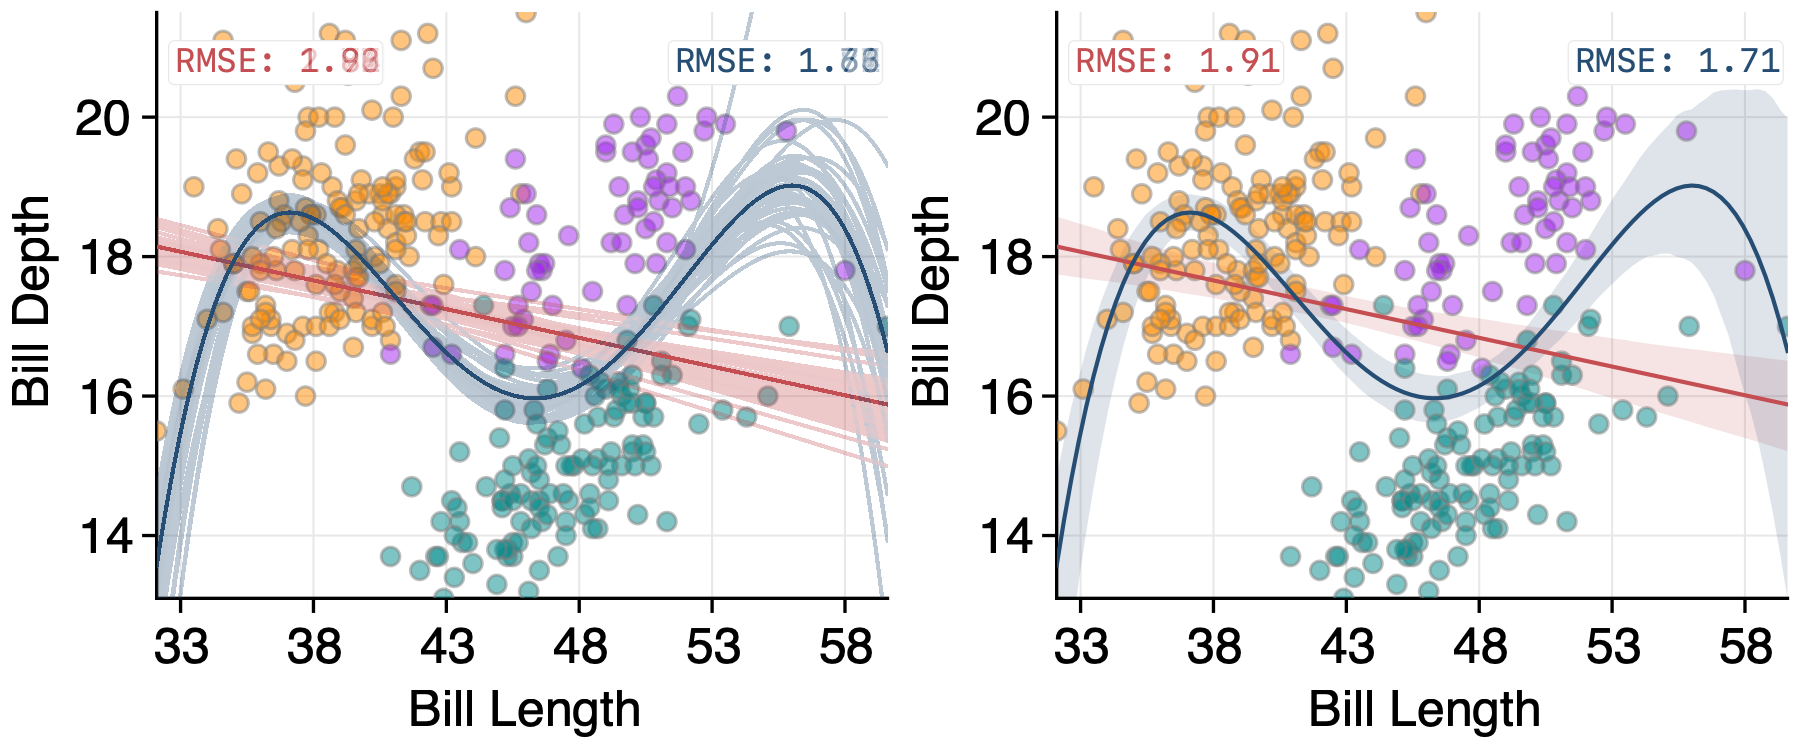

In [13]:
show_images([f'lr_pr_ci_95.png', f'sns_lr_pr_ci_95.png'], f'lr_pr_ci_comparison_95.png')

Another standard scenario arises when the parameter of interest is bivariate. For example, we may be interested in the joint mean of bill length and bill depth, computed separately for each penguin species. Applying $bootplot$ to a bivariate parameter of interest results in uncertainty represented as a colored region.

In [14]:
colors=['#FF8C00', '#A020F0', '#008B8B']
def bivariate_mean(data_subset, data_full, ax, order=0):
    ax.grid(True, linewidth=0.5, color='#E8E8E8', zorder=-1000000)
    ax.set_axisbelow(True)
    for i, species in enumerate(np.unique(data_full[:, 0])):
        subset = data_subset[data_subset[:, 0] == species]
        ax.scatter(np.mean(subset[:, 1]), np.mean(subset[:, 2]), c=colors[i], s=20, alpha=1,
                   edgecolor=colors[i], linewidths=0.75, marker='o', label=species, zorder=10000, antialiased=False)
    for i, species in enumerate(np.unique(data_full[:, 0])):
        subset = data_full[data_full[:, 0] == species]
        ax.scatter(subset[:, 1], subset[:, 2], c="#E8E8E8", s=20, alpha=0.75,
                   edgecolor="#E8E8E8", linewidths=0.75, marker='o', label=species, zorder=5000)
        #ax.scatter(np.mean(subset[:, 1]), np.mean(subset[:, 2]), c=colors[i], s=20, alpha=1,
                   #edgecolor=colors[i], linewidths=0.75, marker='o', label=species, zorder=15000)

    x_min, x_max = data_full[:, 1].min(), data_full[:, 1].max()
    y_min, y_max = data_full[:, 2].min(), data_full[:, 2].max()
    ax.set(xlabel='Bill Length', ylabel='Bill Depth',
           xlim=(x_min, x_max), ylim=(y_min, y_max),
           xticks=np.arange(np.ceil(x_min), np.floor(x_max) + 1, 5),
           yticks=np.arange(np.ceil(y_min), np.floor(y_max) + 1, 2))
    ax.get_figure().set_constrained_layout(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [15]:
np.random.seed(15)
mat = bootplot(
        bivariate_mean,
        penguins_bill_length_depth,
        m=39,
        output_image_path=f'bivariate_mean.png',
        output_size_px = (dpi*3, dpi*2.5),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 22.84it/s]


> Saving bootstrapped image to bivariate_mean.png


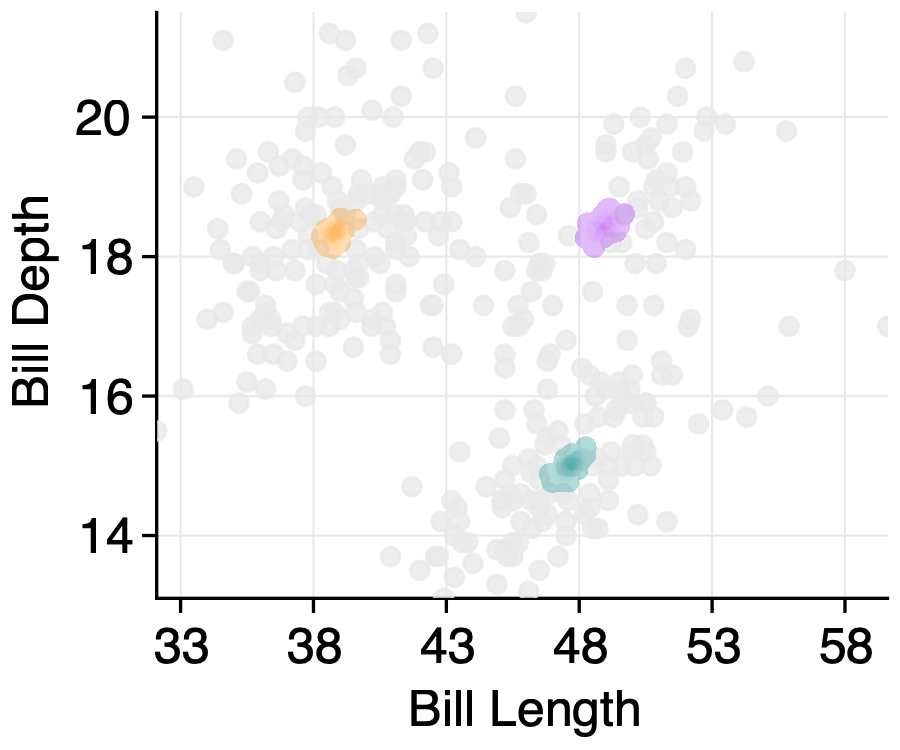

In [16]:
show_images([f'bivariate_mean.png'])

$bootplot$ can also be applied to a bar chart representation of multiple parameters. In the following case, we consider the proportions of penguin species separately, resulting either in an ambiguated bar chart or, if overlaid with point estimates, a bar chart with error bars.

In [17]:
features = ["bill_length_mm"]
species = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['#FFB84D', '#B773F4', '#4DBBBB']
bar_width = 0.7
index = np.arange(len(species))


def bar_chart(data_subset, data_full, ax):
    ax.grid(axis='y', linewidth=0.5, color='#E8E8E8', zorder=-5)
    
    counts = (
        data_subset['species']
        .value_counts(normalize=True)  # Normalize to get proportions
        .reindex(species, fill_value=0)
    ) * 100  # Convert to percentages

    ax.bar(index, counts.values, bar_width,
           color=colors, antialiased=False, zorder=2)

    ax.set(
        ylim=(0, 70),
        xlim=(-0.8, 2.8),
        xticks=index,
        xticklabels=species,
        ylabel="%"
    )

    ax.spines[['top', 'right']].set_visible(False)
    ax.get_figure().set_constrained_layout(True)


        
def error_bar_chart(data_subset, data_full, ax):
    ax.grid(axis='y', linewidth=0.5, color='#E8E8E8', zorder=-5)

    full_counts = data_full['species'].value_counts(normalize=True).reindex(species, fill_value=0) * 100
    subset_counts = data_subset['species'].value_counts(normalize=True).reindex(species, fill_value=0) * 100

    ax.bar(
        index,
        full_counts.values,
        bar_width,
        color=colors,
        antialiased=False,
        zorder=2
    )

    ax.scatter(
        index,
        subset_counts.values,
        color='black',
        antialiased=False,
        s=8,
        marker='s',
        zorder=6
    )

    ax.set(
        ylim=(0, 70),
        xlim=(-0.8, 2.8),
        xticks=index,
        xticklabels=species,
        ylabel="%"
    )
    ax.spines[['top', 'right']].set_visible(False)
    ax.get_figure().set_constrained_layout(True)

In [18]:
np.random.seed(15)
mat = bootplot(
    error_bar_chart,
    penguins,
    m=39,
    output_image_path=f'error_bar_chart_95.png',
    output_size_px =(dpi*3, dpi*2.5),
    verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 36.98it/s]


> Saving bootstrapped image to error_bar_chart_95.png


In [19]:
np.random.seed(15)
mat = bootplot(
    bar_chart,
    penguins,
    m=39,
    output_image_path=f'bar_chart_95.png',
    output_size_px =(dpi*3, dpi*2.5),
    verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 38.77it/s]


> Saving bootstrapped image to bar_chart_95.png


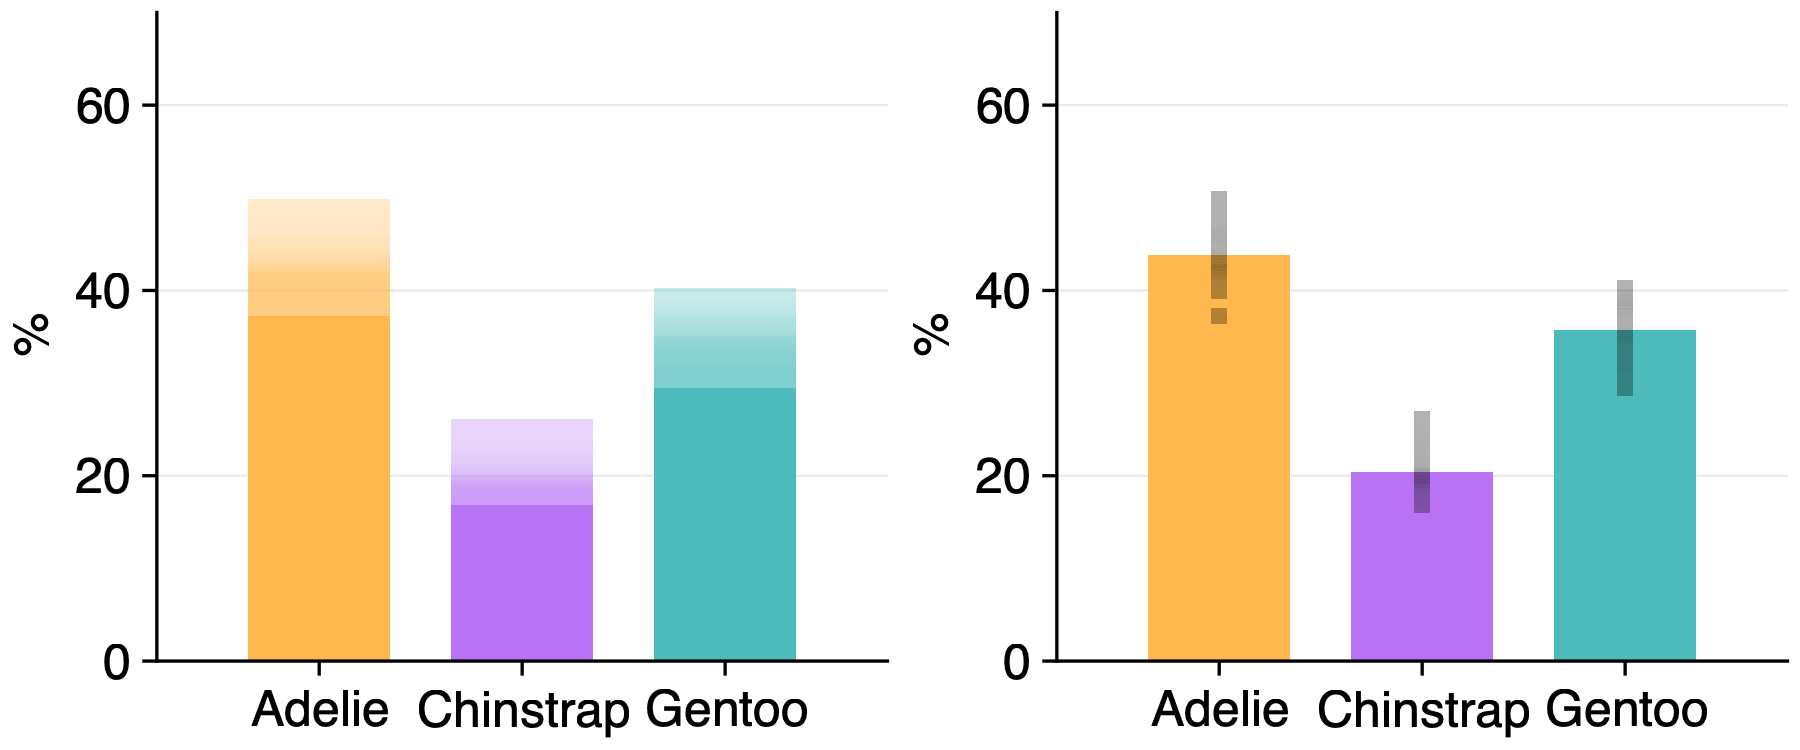

In [20]:
show_images(
        [f'bar_chart_95.png', f'error_bar_chart_95.png'],
        f'bar_chart_comparison95.png'
    )

$bootplot$ also supports less conventional parameters of interest, such as text or probability simplexes, including pie charts and stacked bar charts. In the following examples, we focus on these less typical cases, where uncertainty is rarely visualized in practice.

When asked to visualize parts-of-a-whole, one might naturally choose a pie chart. However, such representations carry uncertainty, and because the components are dependent, with uncertainty taking the form of a probability simplex, visualizing it can be challenging.

Nevertheless, $bootplot$ makes the task straightforward. The user only needs to define how to plot a pie chart.

A potential issue arises when one of the proportions is very small, as its uncertainty may visually obscure it. To mitigate this, we overlay a smaller constant pie chart within each image, making all segments visible.

We now apply this approach to visualize the proportions of penguin species in the dataset.

In [21]:
species_order = ['Adelie', 'Chinstrap', 'Gentoo']
outer_colors = ['#FFB84D', '#B773F4', '#4DBBBB']
inner_colors = ['#FF8C00', '#A020F0', '#008B8B']
r = 0.8

def pie_chart_both(data_subset, data_full, ax):
    species_proportions_out = data_subset['species'].value_counts().reindex(species_order, fill_value=0)
    species_proportions_in = data_full['species'].value_counts().reindex(species_order, fill_value=0)
    species_labels = species_order

    # Set axes position
    ax.set_position([0, 0.1, 1, 0.9])

    # Outer pie (subset)
    outer_wedges, _ = ax.pie(
        species_proportions_out,
        colors=outer_colors,
        startangle=90,
        counterclock=False,
        radius=r,
        wedgeprops={'antialiased': False},
        textprops={'antialiased': False}
    )

    #ax.pie([1], colors=['white'], startangle=90,
        #counterclock=False,
        #radius=11*r / 20, 
        #wedgeprops={'antialiased': False},
        #textprops={'antialiased': False})

    
    # Inner pie (full)
    ax.pie(
        species_proportions_in,
        colors=inner_colors,
        startangle=90,
        counterclock=False,
        radius=r / 2,
        wedgeprops={'antialiased': False},
        textprops={'antialiased': False}
    )


    # Legend
    ax.legend(
        outer_wedges,
        species_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.1),
        ncol=len(species_labels),
        frameon=False,
        handlelength=1,
        handleheight=1,
        handletextpad=0.5,
        columnspacing=0.5
    )

    ax.get_figure().set_constrained_layout(True)


def pie_chart(data_subset, data_full, ax):
    species_order = ['Adelie', 'Chinstrap', 'Gentoo']
    outer_colors = ['#FFB84D', '#B773F4', '#4DBBBB']
    radius = 0.8

    # Get species proportions in fixed order
    species_proportions_out = data_subset['species'].value_counts().reindex(species_order, fill_value=0)
    species_labels = species_order

    # Set axes position
    ax.set_position([0, 0.1, 1, 0.9])

    # Outer pie (subset only)
    outer_wedges, _ = ax.pie(
        species_proportions_out,
        colors=outer_colors,
        startangle=90,
        counterclock=False,
        radius=r,
        wedgeprops={'antialiased': False},
        textprops={'antialiased': False}
    )

    # Legend
    ax.legend(
        outer_wedges,
        species_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.1),
        ncol=len(species_labels),
        frameon=False,
        handlelength=1,
        handleheight=1,
        handletextpad=0.5,
        columnspacing=0.5
    )

    ax.get_figure().set_constrained_layout(True) 

In [22]:
np.random.seed(15)
mat = bootplot(pie_chart,
            penguins,
            m=39,
            output_image_path=f'pie_chart.png',
            output_size_px=(3*dpi, 3*dpi),
            verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:00<00:00, 44.42it/s]


> Saving bootstrapped image to pie_chart.png


In [23]:
np.random.seed(15)
mat_both = bootplot(
        pie_chart_both,
        penguins,
        m=39,
        output_image_path=f'pie_chart_both.png',
        output_size_px=(3*dpi, 3*dpi),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 38.82it/s]


> Saving bootstrapped image to pie_chart_both.png


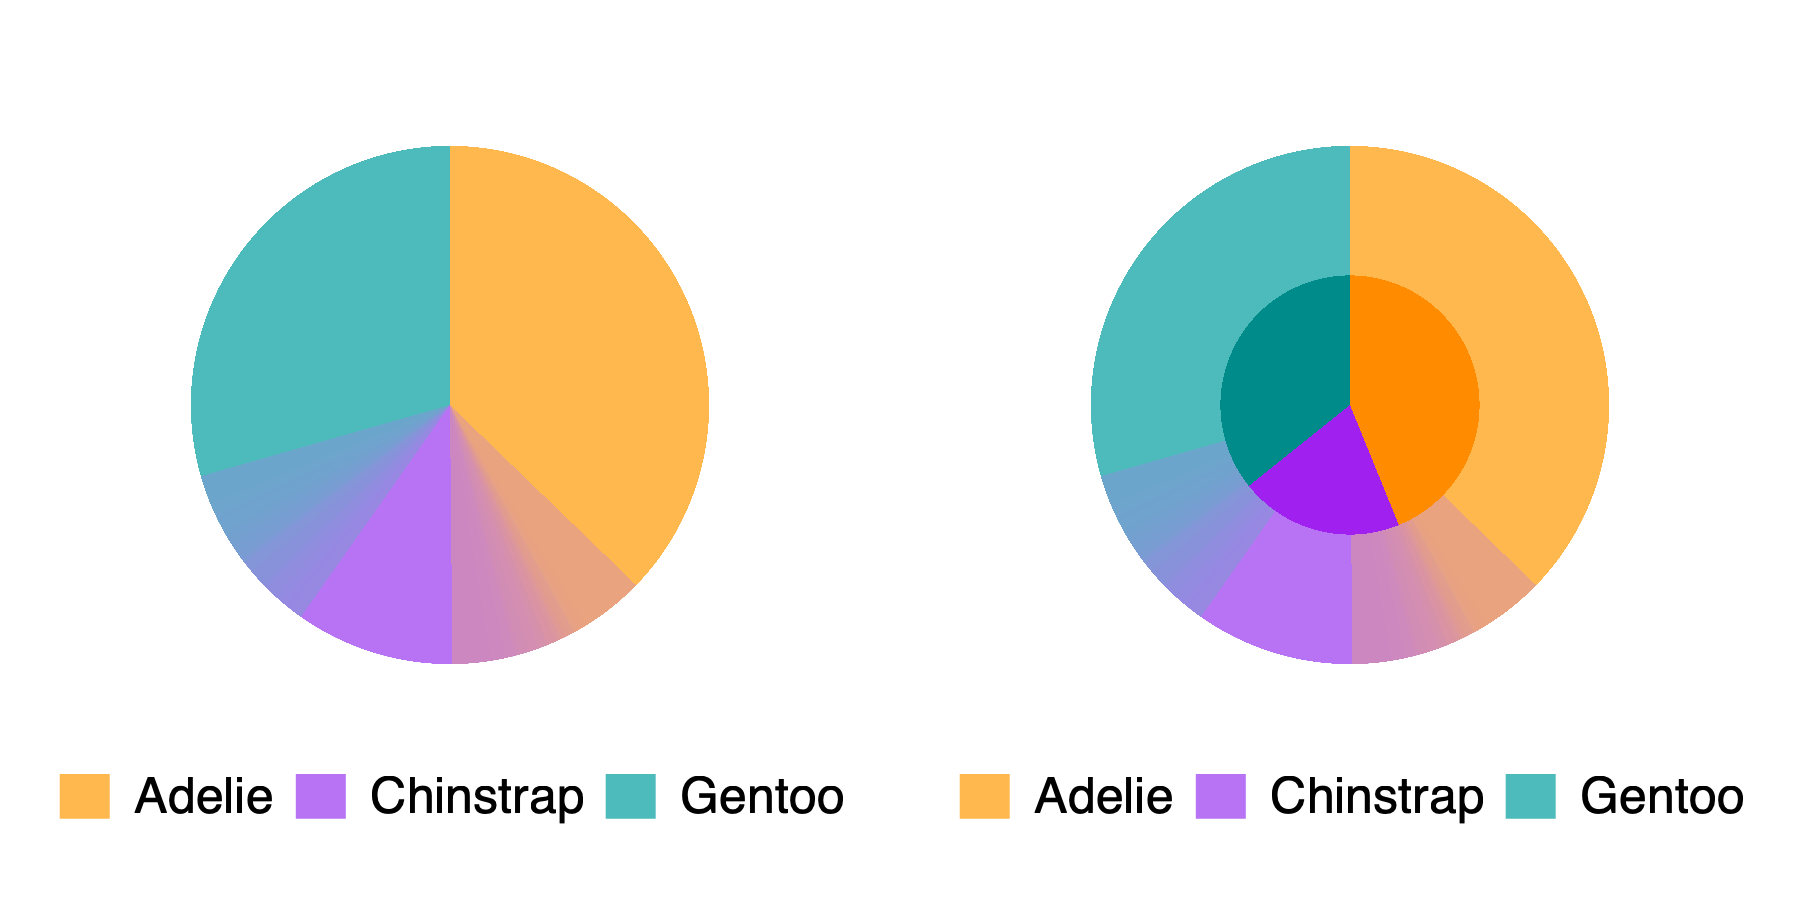

In [24]:
show_images([f'pie_chart.png', f'pie_chart_both.png'], f'pc_comparison.png')

The resulting images are ambiguated pie charts, with an additional smaller constant pie chart overlay in the center to aid interpretation.

However, we need to be mindful when creating pie charts. Too many slices, especially very thin ones, can easily become obscured by the uncertainty in other categories. To illustrate this, let's create a pie chart with nine different slices based on species, examining the proportions of penguins with shallow, medium, and deep bill depths. The full pie is visible inside, but the uncertainty causes the smaller slices to disappear, making the visualization difficult to interpret.

In [25]:
def pie_chart_failure(data_subset, data_full, ax):
    species_order = ['Adelie', 'Chinstrap', 'Gentoo']
    radius = 0.8

    # Hard-coded boundaries for bill depth groups
    def depth_bin(x):
        if x < 16.75:
            return "shallow"
        elif x < 17.25:
            return "medium"
        else:
            return "deep"

    group_order = ['shallow', 'medium', 'deep']

    # Subset counts
    counts = pd.crosstab(
        data_subset['species'],
        data_subset['bill_depth_mm'].apply(depth_bin)
    ).reindex(index=species_order, columns=group_order, fill_value=0)
    values = counts.values.flatten()

    # Full-data counts
    counts_full = pd.crosstab(
        data_full['species'],
        data_full['bill_depth_mm'].apply(depth_bin)
    ).reindex(index=species_order, columns=group_order, fill_value=0)
    values_full = counts_full.values.flatten()
    # Base colors in canonical (species_order × group_order) order
    
    #colors = ["#FFB84D", "#FF8C00", "#CC6A00","#B773F4", "#A020F0", "#6E2E9E", "#4DBBBB", "#008B8B", "#176060"]
    #colors = ["#FFB84D", "#264d73", "#FF8C00","#B773F4", '#C0C0C0', "#A020F0", "#4DBBBB", '#c44e52', "#008B8B"]
    colors = ["#FF8C00", "#264d73", "#FFB84D","#A020F0", '#C0C0C0',"#B773F4", "#4DBBBB", '#c44e52', "#008B8B"]

    sorted_idx = np.argsort(values_full)[::-1]

    values_full_sorted = values_full[sorted_idx]
    values_sorted = values[sorted_idx]

    colors_sorted = [colors[i] for i in sorted_idx]

    ax.set_position([0, 0.2, 1, 0.8])


    ax.pie(
        values_sorted,
        colors=colors_sorted,
        startangle=90,
        counterclock=False,
        radius=radius,
        wedgeprops={'antialiased': False},
        textprops={'antialiased': False}
    )

    
    ax.pie(
        values_full_sorted,
        colors=colors_sorted,
        startangle=90,
        counterclock=False,
        radius=radius / 2,
        wedgeprops={'antialiased': False},
        textprops={'antialiased': False}
    )

    color_matrix = np.array(colors).reshape(len(species_order), len(group_order)).T

    table = ax.table(
        cellColours=color_matrix,
        rowLabels=group_order,
        colLabels=species_order,
        loc='lower center',
        cellLoc='center',
        bbox=[0.3, -0.1, 0.6, 0.20]
    )

    for cell in table.get_celld().values():
        cell.set_edgecolor("white")

    ax.get_figure().set_constrained_layout(True)


In [26]:
np.random.seed(15)
mat = bootplot(pie_chart_failure,
            penguins,
            m=39,
            output_image_path=f'pie_chart_failure.png',
            output_size_px=(3*dpi, 3*dpi),
            verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 29.62it/s]


> Saving bootstrapped image to pie_chart_failure.png


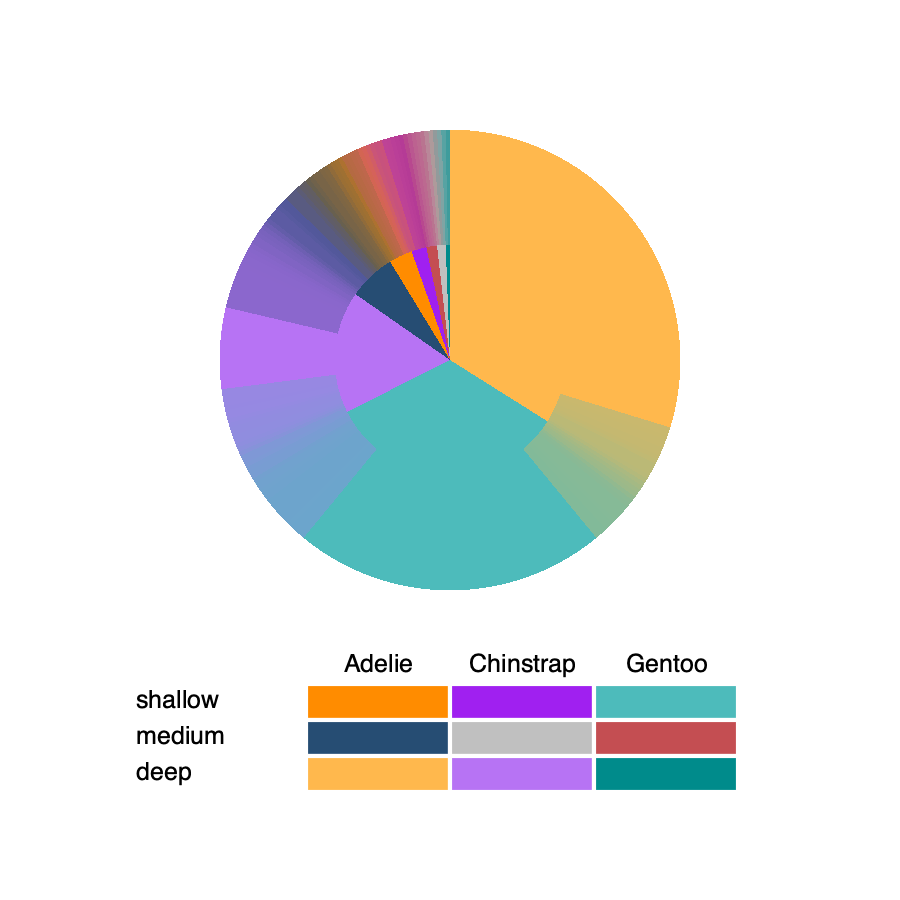

In [27]:
show_images([f'pie_chart_failure.png'])

Indeed, in many real-world scenarios, we work with data whose uncertainty takes the form of a probability simplex. This includes proportions of people with a certain eye color, hair color, or, as in the previous example with penguins, proportions of different species. These are datasets in which the components sum to one or to one hundred percent.

While pie charts are commonly used for such data, it is often represented using stacked bar charts or, in some cases, regular bar charts. The latter can be misleading, as it disregards the compositional nature of the uncertainty.

$bootplot$ can be applied in these settings as well. As with pie charts, small parts may become obscured when uncertainty is introduced. One way to address this is to show half of the stacked bar chart without uncertainty, making sure that all components remain clearly visible.

In [28]:
species = ['Adelie', 'Chinstrap', 'Gentoo']
colors_top = ['#FF8C00', '#A020F0', '#008B8B']
colors_bottom = ['#FFB84D', '#B773F4', '#4DBBBB']

def stacked_bar(data_subset, _, ax):
    counts = data_subset['species'].value_counts()
    props = np.array([counts.get(s, 0) for s in species], dtype=float)
    props = props / props.sum() * 100 if props.sum() > 0 else np.zeros_like(props)
    lefts = np.insert(np.cumsum(props[:-1]), 0, 0)
    
    ax.barh(
        y=-0.4, width=props, left=lefts,
        height=1.4, color=colors_bottom,
        edgecolor='none', linewidth=0,
        antialiased=False, align='edge'
    )
    
    for pos, ha, label in zip([0, 50, 100], ['left', 'center', 'right'], species):
        ax.text(pos, -0.6, label, ha=ha, va='top')
    
    ax.set(xlim=(0, 100), ylim=(-1.5, 1.2))
    ax.axis('off')
    ax.get_figure().set_constrained_layout(True)


def stacked_bar_both(data_subset, data_full, ax):
    def get_props(data):
        counts = data['species'].value_counts()
        props = np.array([counts.get(s, 0) for s in species], dtype=float)
        props = props / props.sum() * 100 if props.sum() > 0 else np.zeros_like(props)
        lefts = np.insert(np.cumsum(props[:-1]), 0, 0)
        return props, lefts
        
    full_props, full_lefts = get_props(data_full)
    subset_props, subset_lefts = get_props(data_subset)
    
    for y, props, lefts, colors in [(0.3, subset_props, subset_lefts, colors_bottom), (-0.4, full_props, full_lefts, colors_top)]:
        ax.barh(y=y, width=props, left=lefts, height=0.7, color=colors, edgecolor='none', linewidth=0, antialiased=False, align='edge')
    
    for pos, ha, label in zip([0, 50, 100], ['left', 'center', 'right'], species):
        ax.text(pos, -0.6, label, ha=ha, va='top')
    
    ax.set(xlim=(0, 100), ylim=(-1.5, 1.2))
    ax.axis('off')
    ax.margins(x=0)
    ax.get_figure().set_constrained_layout(True)

In [29]:
np.random.seed(15)
mat = bootplot(
    stacked_bar_both,
    penguins,
    m=39,
    output_image_path=f'stacked_bar_both.png',
    output_size_px=(6*dpi, 0.75*dpi),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:00<00:00, 74.16it/s]


> Saving bootstrapped image to stacked_bar_both.png


In [30]:
np.random.seed(15)
mat = bootplot(
    stacked_bar,
    penguins,
    m=39,
    output_image_path=f'stacked_bar.png',
    output_size_px=(6*dpi, 0.75*dpi),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:00<00:00, 80.37it/s]


> Saving bootstrapped image to stacked_bar.png


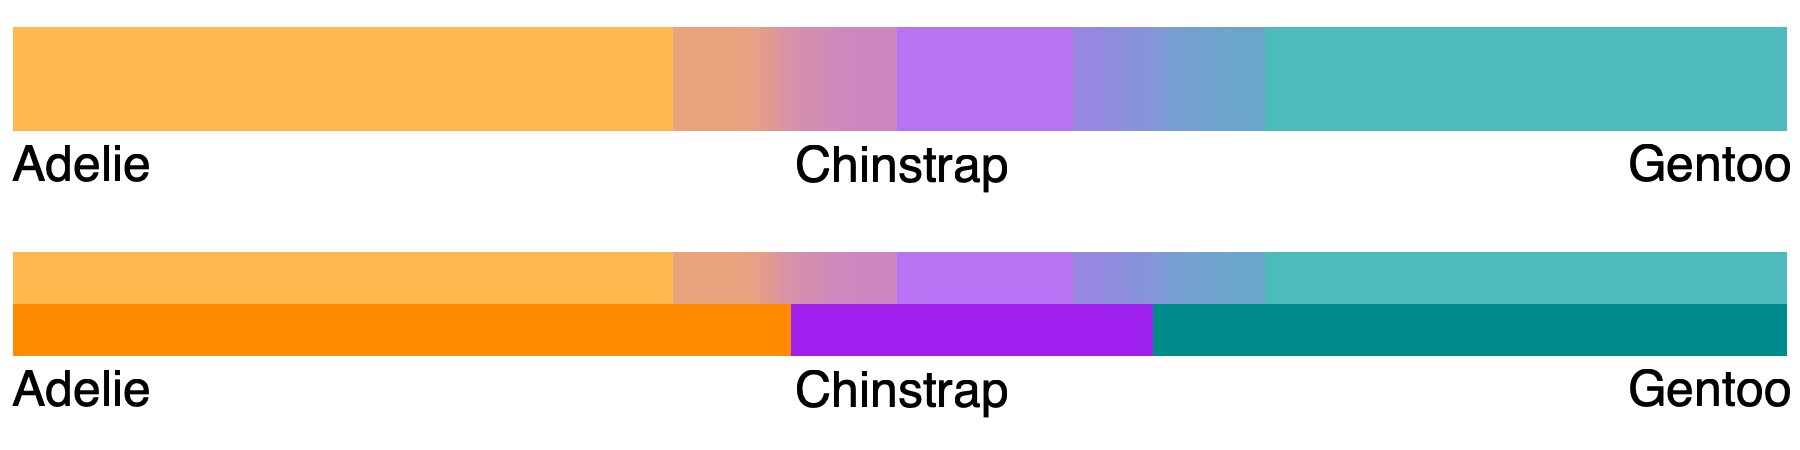

In [31]:
show_images([f'stacked_bar.png', f'stacked_bar_both.png'], f'sb_comparison.png', above=True)

A bubble chart is commonly defined in two distinct ways. The first definition treats it as a scatter plot in which two variables are encoded by the x- and y-coordinates, while a third variable is represented by the area (or radius) of each bubble. The second definition considers it a visualization where relationships between objects are encoded solely by bubble area, with x- and y-coordinates serving a primarily aesthetic or spatial-arrangement function (bubbles typically touch or cluster rather than correspond to quantitative axes). Here  we illustrate both interpretations. For the latter, however, we fix the bubble positions and vary only their sizes to reflect uncertainty. In contrast, under the first interpretation we represent uncertainty across all three variables.

In [32]:
species_order = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['#FFB84D', '#B773F4', '#4DBBBB']
def bubble_chart(data_subset, data_full, ax, order=0):
    #ax.grid(True, linewidth=0.5, color='#E8E8E8', zorder=-1000000)
    #ax.set_axisbelow(True)

    from matplotlib.patches import Circle

    for i, species in enumerate(species_order):
        subset = data_subset[data_subset.iloc[:, 0] == species]
    
        x = np.mean(subset.iloc[:, 2])
        y = np.mean(subset.iloc[:, 3])
        r = np.mean(subset.iloc[:, 4]) / 100 
        circle = Circle((x, y), r,
                        facecolor=colors[i],
                        edgecolor="none",
                        alpha=1,
                        zorder=10000,
                       antialiased=False)
        ax.add_patch(circle)

    
    x_min, x_max = data_full.iloc[:, 2].min(), data_full.iloc[:, 2].max()
    y_min, y_max = data_full.iloc[:, 3].min(), data_full.iloc[:, 3].max()
    ax.set(xlabel='Bill Length', ylabel='Bill Depth',
           xlim=(x_min, x_max-5), ylim=(y_min-9, y_max+1),
           xticks=np.arange(np.ceil(x_min), np.floor(x_max) - 5, 5),
           yticks=np.arange(np.ceil(y_min)-9, np.floor(y_max) + 1, 5)
          )
    ax.grid(True, linewidth=0.5, color="#E8E8E8"); ax.set_axisbelow(True)
 

    
    from matplotlib.patches import Circle
    
    x_pos   = 38
    x_text  = 41
    y_pos   = [8, 10, 12]            # ← HARD-CODED vertical positions
    radii   = [2, 1.5, 1]             # ← big → medium → small
    labels  = ["200", "150", "100"]
    
    for y, r, lab in zip(y_pos, radii, labels):
        ax.add_patch(Circle((x_pos, y), radius=r, fill=False))
        ax.text(x_text, y, lab, va="center")
    ax.text(34, 14, "Flipper Length", va="center")


    ax.get_figure().set_constrained_layout(True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

In [33]:
np.random.seed(15)
mat = bootplot(
        bubble_chart,
        penguins,
        m=39,
        output_image_path=f'bubble_chart.png',
        output_size_px = (dpi*3, dpi*2.5),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 31.16it/s]


> Saving bootstrapped image to bubble_chart.png


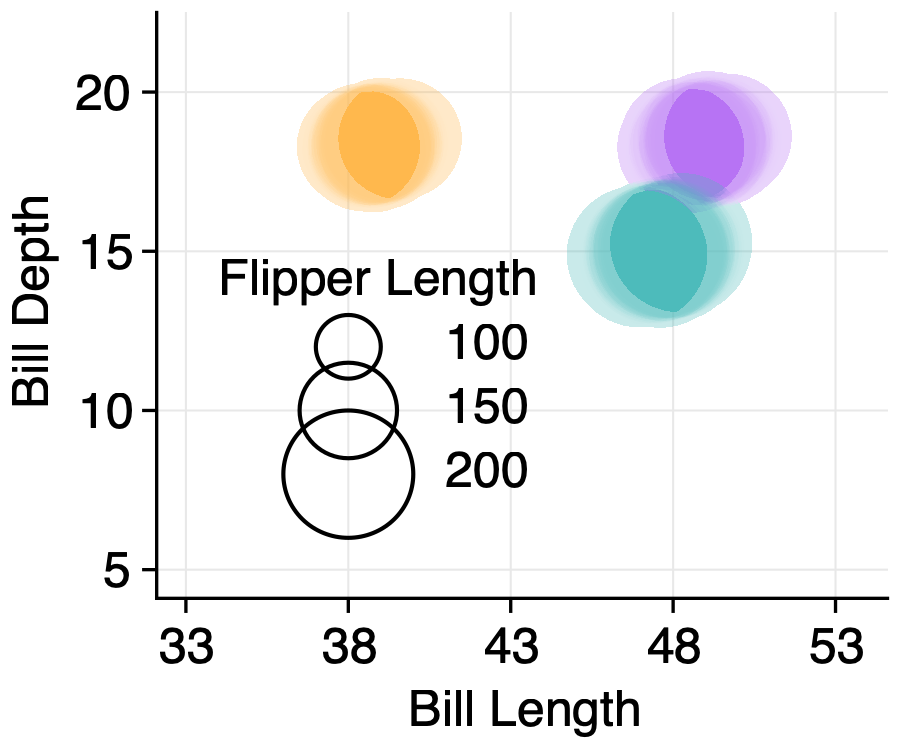

In [34]:
show_images([f'bubble_chart.png'])

In [35]:
species_order = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['#FFB84D', '#B773F4', '#4DBBBB']
centers = [(0, 1), (2, -1.5), (3, 3)]
def bubble_chart_proportions(data_subset, data_full, ax):
    subset_proportions = data_subset["species"].value_counts(normalize=True).reindex(species_order, fill_value=0)
    radius = [4 * subset_proportions[s] for s in species_order]

    for (x, y), r, color, sp in zip(centers, radius, colors, species_order):
        ax.pie(
            [1],
            colors=[color],
            radius=r,
            center=(x, y),
            wedgeprops={'antialiased': False},
            textprops={'antialiased': False}
        )
        ax.text(x, y, sp, ha='center', va='center', color='black')

    ax.set(aspect='equal', xlim=(-2, 4.75), ylim=(-2, 5))
    ax.axis('off')
    ax.set_position([0, 0.1, 1, 0.9])
    ax.figure.set_constrained_layout(True)

In [36]:
np.random.seed(15)
mat = bootplot(
    bubble_chart_proportions,
    penguins,
    m=39,
    output_image_path=f'bubble_chart_proportions.png',
    output_size_px=(3*dpi, 3*dpi),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:00<00:00, 43.98it/s]


> Saving bootstrapped image to bubble_chart_proportions.png


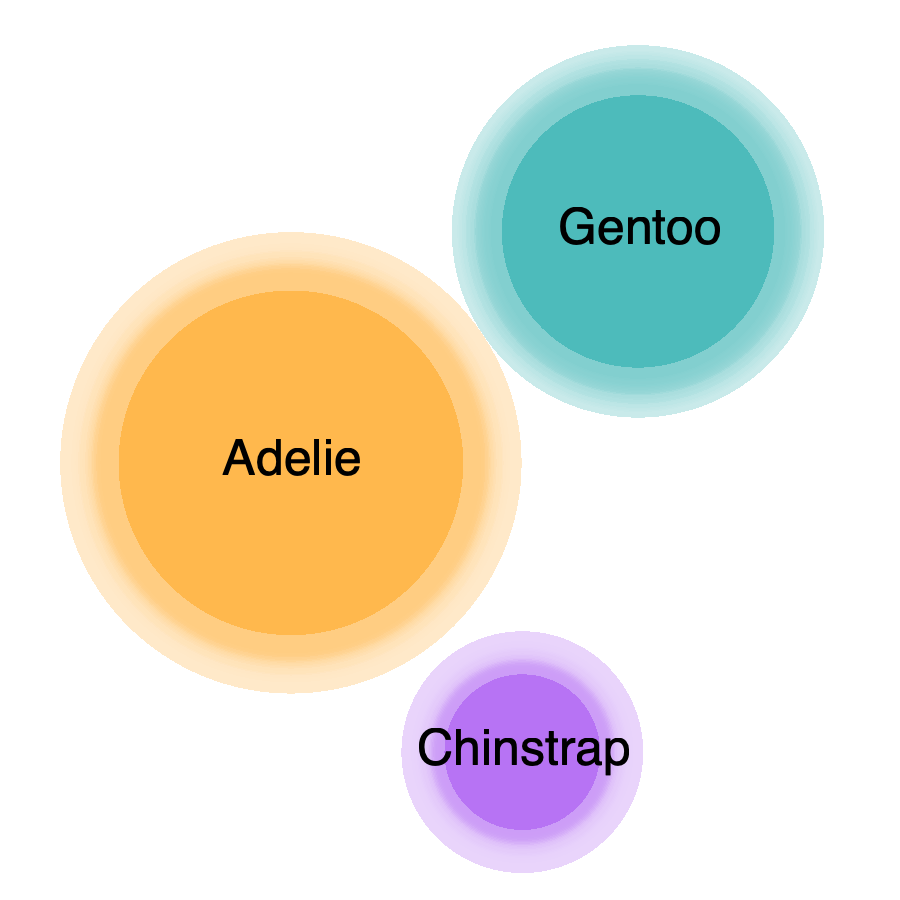

In [37]:
show_images([f'bubble_chart_proportions.png'])

In medical research, proportions often represent counts of healthy versus sick individuals or similar categories. These proportions are frequently visualized using icon arrays. $bootplot$ can be applied to icon arrays as well.

Here, we use the Python library pywaffle to generate waffle charts (a type of icon array) based on the proportions of penguin species. In the resulting visualization, uncertainty is visualized through variations in the color of the individual squares. Instead of squares we can also depict uncertainty with images as icons (Adelie penguin icon from <a href="https://www.flaticon.com/free-icons/penguin" title="penguin icons">Penguin icons created by Three musketeers - Flaticon</a>, accessed at Nov 21 2025).

In [38]:
def waffle_chart(data_subset, data_full, ax):
    species = ["Adelie", "Chinstrap", "Gentoo"]
    adelie_count = (data_subset['species'] == 'Adelie').sum()
    total = len(data_subset)
    adelie_pct = round((adelie_count / total) * 100) if total > 0 else 0
    other_pct = 100 - adelie_pct
    
    values = {
        "Adelie": adelie_pct,
        "Not Adelie": other_pct
    }
    
    Waffle.make_waffle(
        ax=ax,
        values=values,
        rows=10,
        colors=['#FFB84D', '#C0C0C0'],  # Adelie and Other
        legend={
            'loc': 'lower center', 'bbox_to_anchor': (0.5, 0),
            'ncol': 2, 'frameon': False,
            'handlelength': 0.8, 'handleheight': 0.8,
            'handletextpad': 0.25, 'columnspacing': 0.25
        },
        vertical=True
    )
    
    ax.set(xlim=(0, 1), ylim=(-0.2, 1))
    ax.get_figure().set_constrained_layout(True)

In [39]:
np.random.seed(15)
mat = bootplot(
        waffle_chart,
        penguins,
        m=39,
        output_image_path=f'waffle_chart.png',
        verbose=True,
        output_size_px =(dpi*3, dpi*3)
    )

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 31.88it/s]


> Saving bootstrapped image to waffle_chart.png


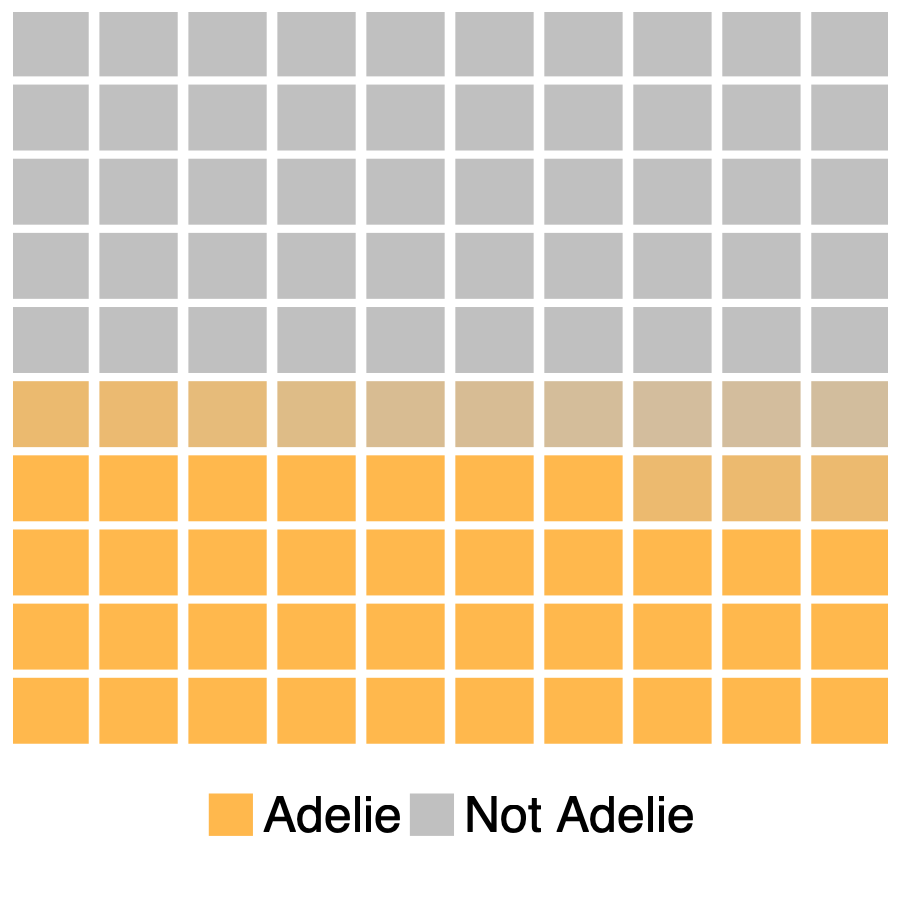

In [40]:
show_images([f'waffle_chart.png'])

In [41]:
def pictogram(data_subset, data_full, ax):
    species = ["Adelie", "Chinstrap", "Gentoo"]
    adelie_count = (data_subset['species'] == 'Adelie').sum()
    total = len(data_subset)
    adelie_pct = round((adelie_count / total) * 100) if total > 0 else 0
    
    rows = cols = 10

    img_A = mpimg.imread("adelie.png")
    img_B = mpimg.imread("X-adelie.png")

    for i in range(100):
        img = img_A if i < adelie_pct else img_B

        row = i // cols     
        col = i % cols   

        x0, y0 = col, row
        x1, y1 = x0 + 1, y0 + 1

        ax.imshow(img, extent=[x0 + 0.1, x1 - 0.1, y0 + 0.1, y1 - 0.1])

    ax.imshow(img_A, extent=[1.3, 2.1, -1.4, -0.6])
    ax.text(2.1, -1, "Adelie", va="center", ha="left", fontsize=20)

    ax.imshow(img_B, extent=[4.4, 5.2, -1.4, -0.6])
    ax.text(5.2, -1, "Not Adelie", va="center", ha="left", fontsize=20)

    ax.set_xlim(0, cols)
    ax.set_ylim(-1.5, rows+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [42]:
np.random.seed(15)
mat = bootplot(
        pictogram,
        penguins,
        m=39,
        output_image_path=f'pictogram.png',
        verbose=True,
        output_size_px =(dpi*6, dpi*6)
    )

Generating plots: 100%|█████████████████████████| 39/39 [00:16<00:00,  2.39it/s]


> Saving bootstrapped image to pictogram.png


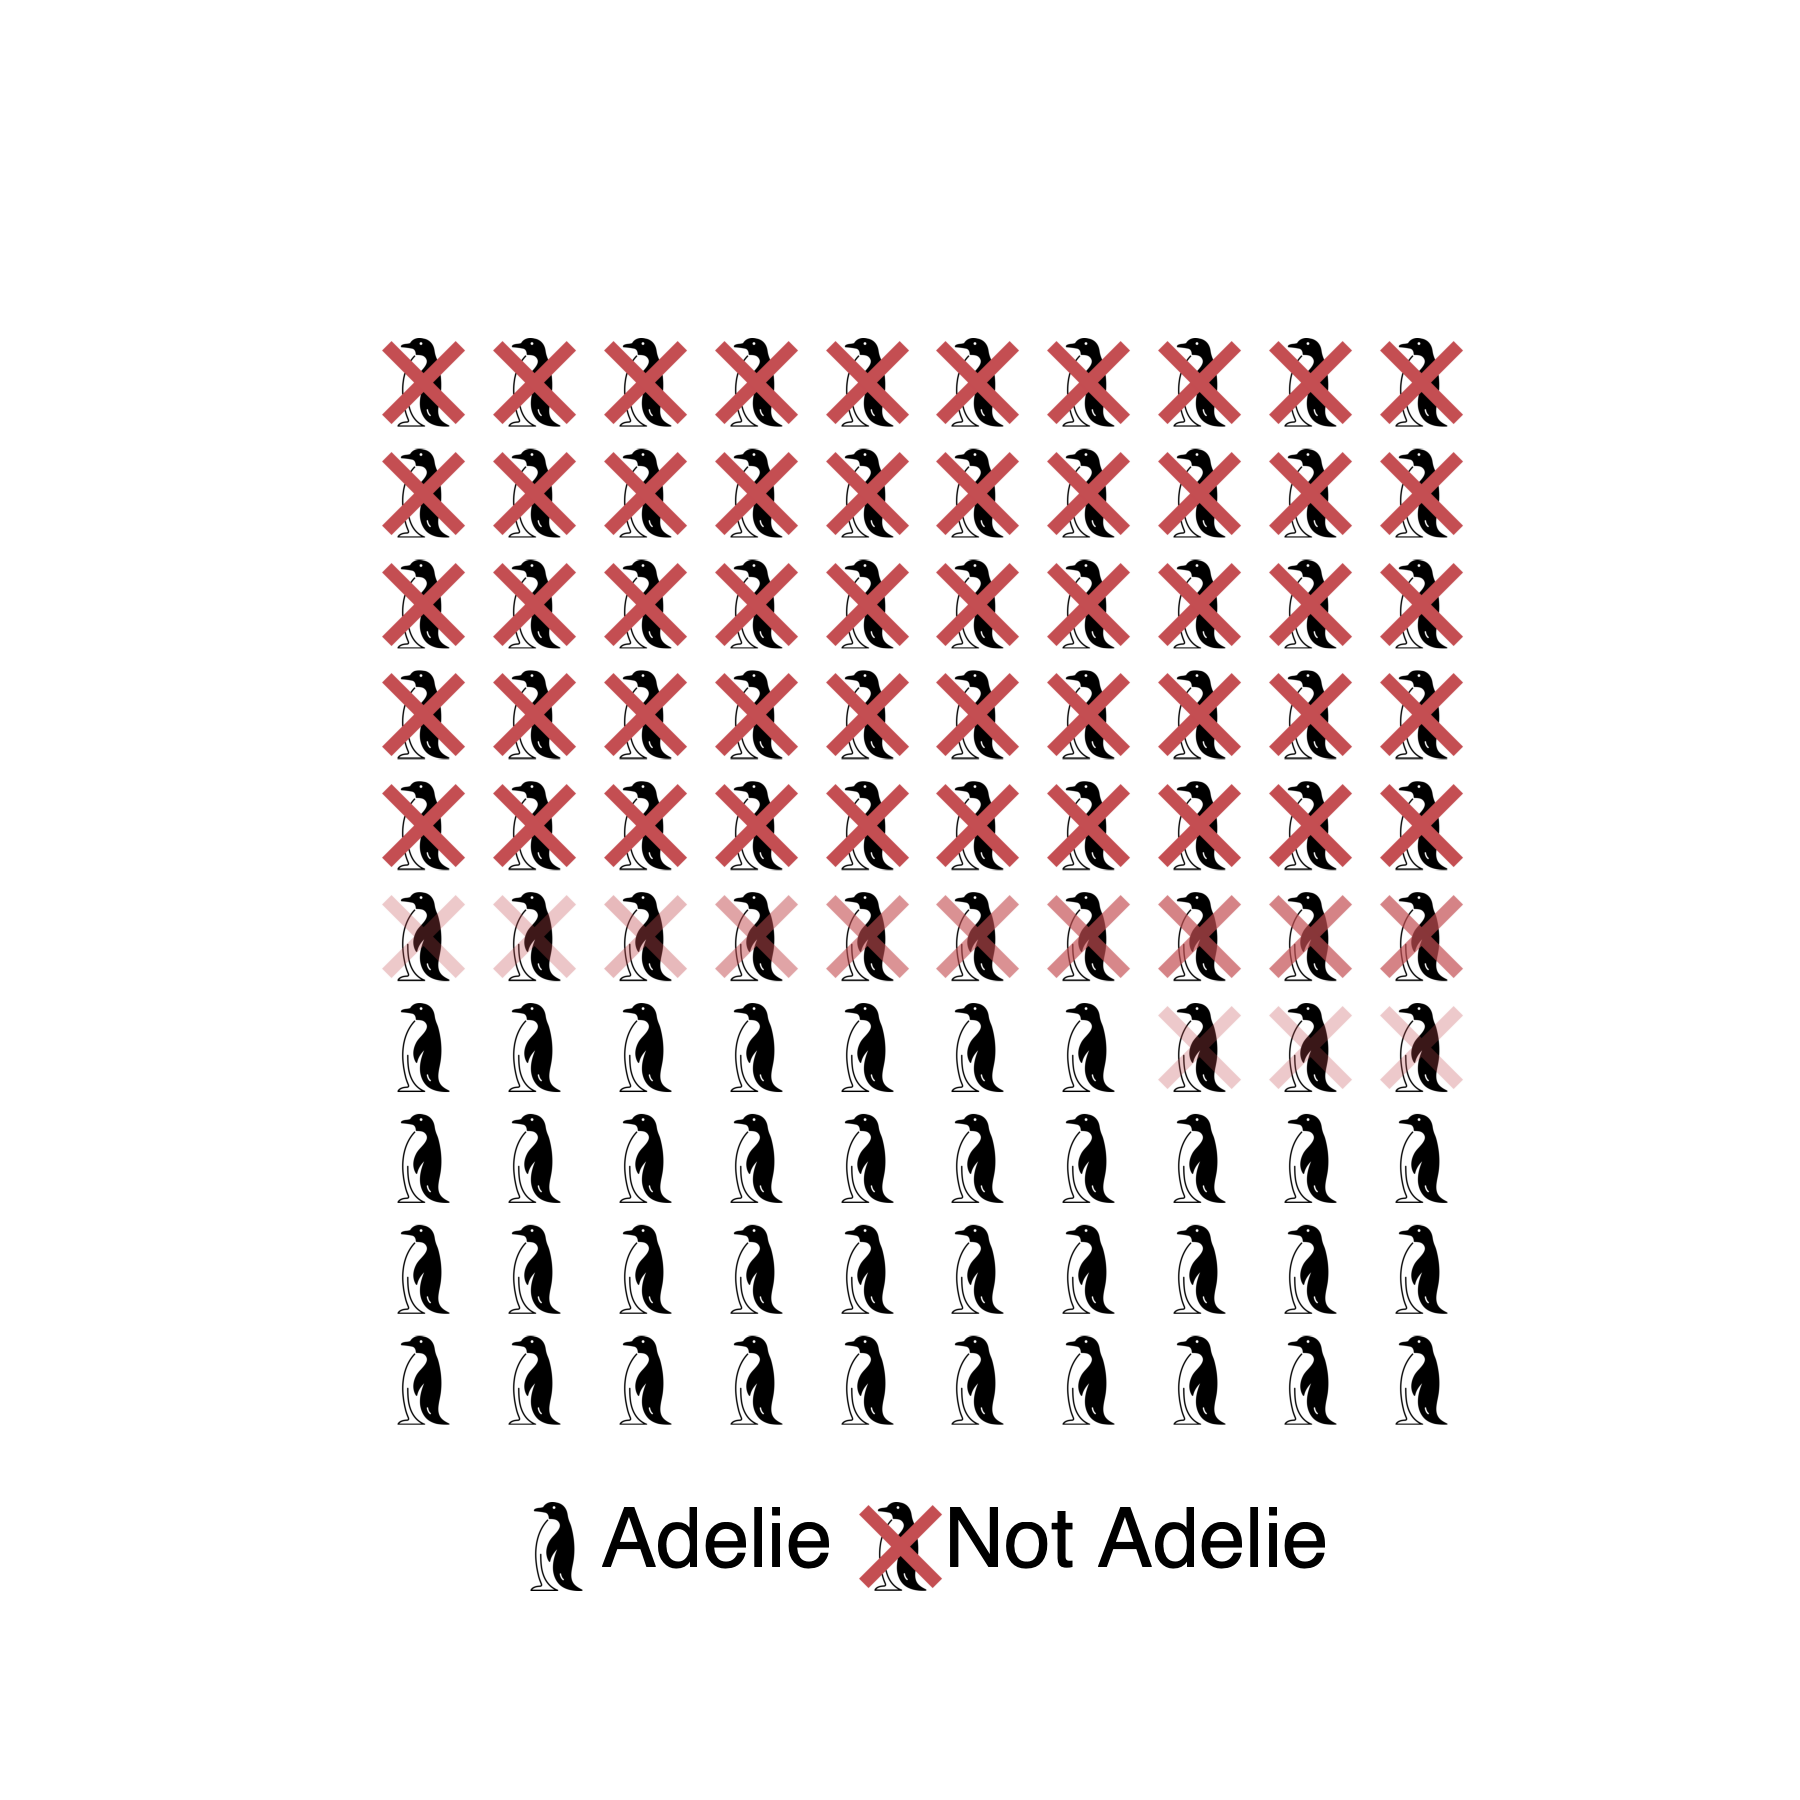

In [43]:
show_images([f'pictogram.png'])

Tables and text, when presented visually, are also two-dimensional visualizations. As such, we can apply $bootplot$ to them as well. The resulting uncertainty is shown through blurriness in the output image.

In [44]:
mono_font = font_manager.FontProperties(fname='/System/Library/Fonts/SFNSMono.ttf')
np.random.seed(1)
font_size = 12
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
labels = ['Bill L.', 'Bill D.', 'Flipper L.']
colors = ['#FFB84D', '#B773F4', '#4DBBBB']

def make_table(data_subset, data_full, ax):
        means = data_subset.groupby('species')[cols].mean().T.round(1)
        cell_text = [[f'{val: .1f}' for val in row] for row in means.values]
        tbl = ax.table(
            cellText=cell_text,
            colLabels=means.columns,
            rowLabels=labels,
            loc='center',
            bbox=[0.0, 0.0, 1.0, 0.9]
        )
    
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(font_size)  # <-- THIS controls the number size in rows

    
        for (row, col), cell in tbl.get_celld().items():
            if row == 0:  # Header row
                cell.set_facecolor(colors[col])
                cell.set_text_props(ha='center', va='center')
            elif col == -1:  # Row labels
                cell.set_facecolor('#E8E8E8')
                cell.set_text_props(ha='center', va='center')
            else:  # Data cells
                cell.set_text_props(ha='center', va='center', fontproperties=mono_font, fontsize=font_size)
    
        ax.axis('off')
        ax.axis('tight')
        ax.get_figure().set_constrained_layout(True)

In [45]:
np.random.seed(15)
mat = bootplot(
        make_table,
        penguins,
        m=39,
        output_image_path=f'table.png',
        output_size_px=(6*dpi, 1.5*dpi),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 34.97it/s]


> Saving bootstrapped image to table.png


Means, as point estimates, are typically communicated using calculated confidence intervals. We now generate a standard table with confidence intervals so we can compare it to the $bootplot$ visualization.

In [46]:
data=penguins
grouped = data.groupby('species')[cols]

means = grouped.mean().round(1)
margins = grouped.sem() * stats.t.ppf(0.975, df=grouped.count() - 1)

formatted = grouped.mean().copy()
for col in cols:
    formatted[col] = [f"{m:.1f}±{e:.1f}" for m, e in zip(means[col], margins[col])]

fig, ax = plt.subplots(figsize=(6,1.5), dpi=dpi, layout="constrained")
table = ax.table(
    cellText=formatted.T.values,
    colLabels=formatted.index.tolist(),
    rowLabels=labels,
    loc='center',
    bbox=[0.0, 0.0, 1.0, 0.9]
)

table.auto_set_font_size(False)
table.set_fontsize(font_size)

for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header row
            cell.set_facecolor(colors[col])
            cell.set_text_props(ha='center', va='center')
        elif col == -1:  # Row labels
            cell.set_facecolor('#E8E8E8')
            cell.set_text_props(ha='center', va='center')
        else:  # Data cells
            cell.set_text_props(ha='center', va='center', fontproperties=mono_font, fontsize=font_size)


ax.axis('off')
plt.savefig(f'reg_table.png', format='png')
plt.close()

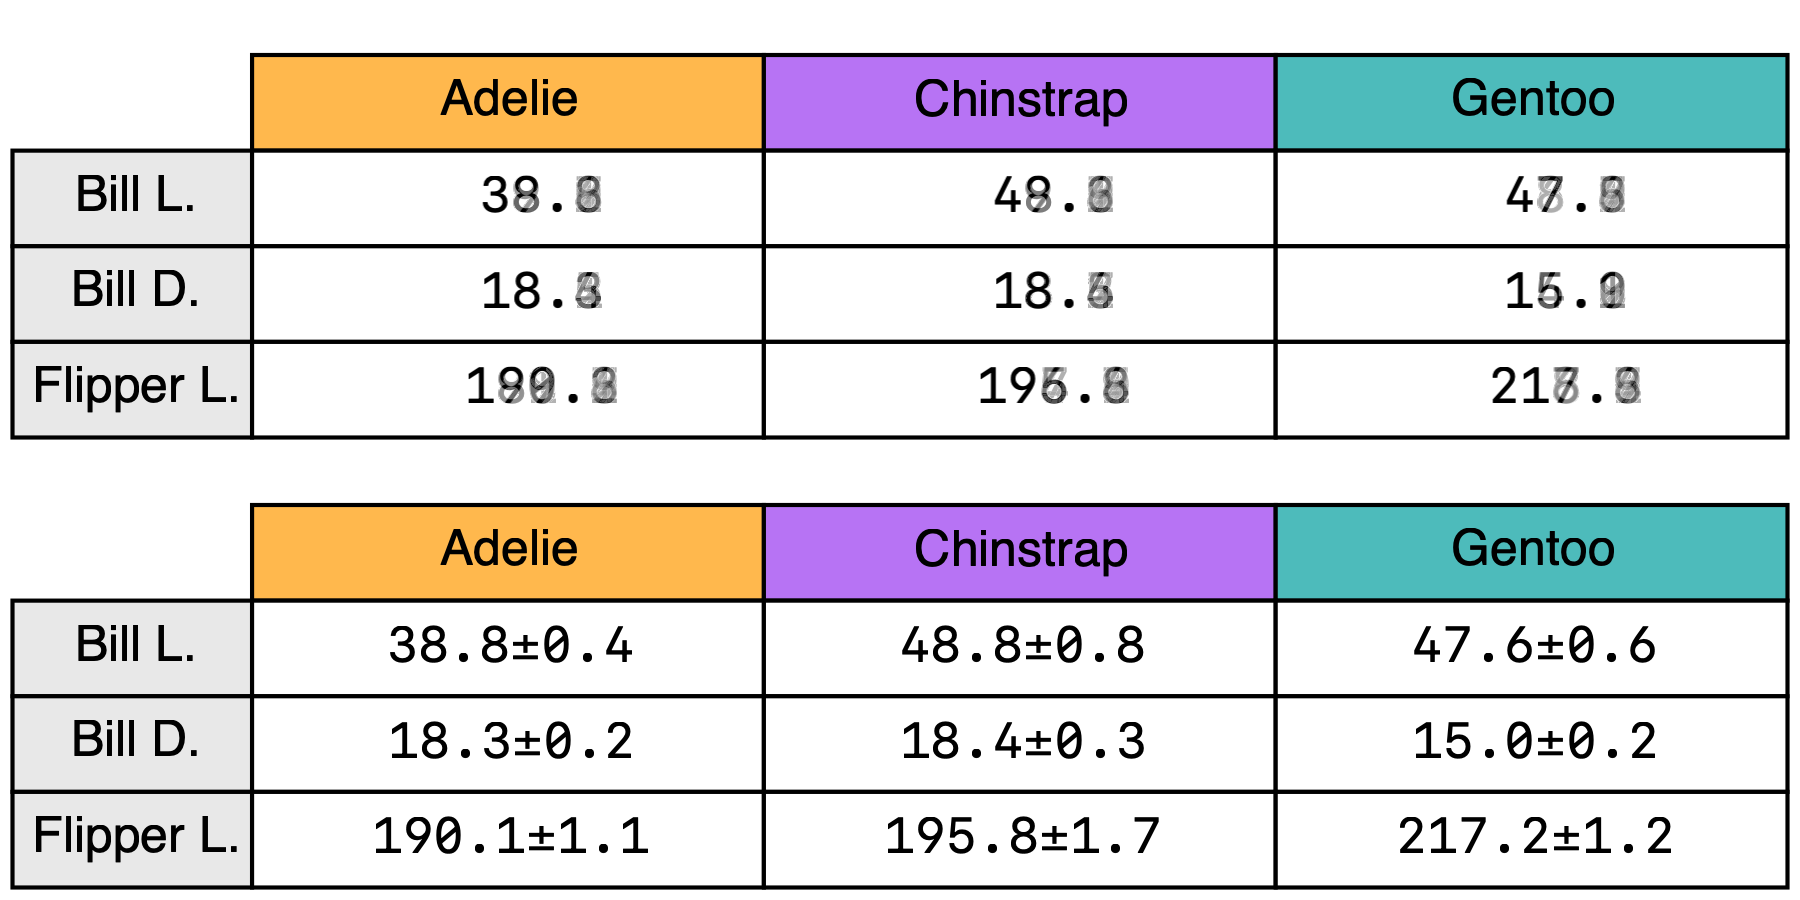

In [47]:
show_images([f'table.png', f'reg_table.png'], f'table_comparison.png', above=True)

Another example is when the parameter of interest is the PCA loadings vector. We compute eigenvectors from each subset and from the full dataset, then plot their loading directions. To keep the directions consistent, each subset’s eigenvectors is compared to the full-data eigenvectors and flipped when needed. The full-data eigenvectors are also used to create the gray background projection. The final $bootplot$ visualization shows how the loading directions vary across the bootstrapped subsets, giving a sense of their uncertainty

In [48]:
penguins_standardized = StandardScaler().fit_transform(penguins.iloc[:, 2:5].to_numpy())
_, _, vh = np.linalg.svd(penguins_standardized, full_matrices=False)
ev_expected = vh.T[:, [0, 1]]
projection_expected = penguins_standardized @ ev_expected

feature_names = ['Bill length', 'Bill depth', 'Flipper length']
colors_loadings = ['#264d73', '#c44e52', '#1a1a1a']

def PCA_loadings(data_subset, data_full, ax):
    _, _, vh = np.linalg.svd(data_subset, full_matrices=False)
    ev = vh.T[:, [0, 1]]

    # orientation check (same direction as expected)
    if np.dot(ev_expected[:, 0], ev[:, 0]) < 0:
        ev[:, 0] = -ev[:, 0]
    if np.dot(ev_expected[:, 1], ev[:, 1]) < 0:
        ev[:, 1] = -ev[:, 1]

    # loadings (subset)
    for i in range(3):
        ax.plot(
            [0, ev[i, 0] * 2],
            [0, ev[i, 1] * 2],
            color=colors_loadings[i],
            linewidth=1,
            antialiased=False
        )

    # loadings (expected)
    for i in range(3):
        ax.plot(
            [0, ev_expected[i, 0] * 2],
            [0, ev_expected[i, 1] * 2],
            color=colors_loadings[i],
            linewidth=1,
            antialiased=False
        )

    # expected projection (based on expected eigenvectors, background)
    ax.scatter(
        projection_expected[:, 0], projection_expected[:, 1],
        c="#E8E8E8", s=20, alpha=0.75,
        edgecolor="#E8E8E8", linewidths=0.75,
        marker='o', zorder=-100
    )

    for i in range(3):
        x, y = ev_expected[i] * 2
        ax.text(
            x * 1.9, y * 1.15,
            feature_names[i],
            color=colors_loadings[i],
            fontsize=8,
            ha='center', va='center',
            zorder=100001
        )

    ax.set(
        xlabel='Principal Component 1',
        ylabel='Principal Component 2',
        xlim=(-4, 4), ylim=(-4, 4),
        xticks=np.arange(-3, 5, 2),
        yticks=np.arange(-3, 5, 2)
    )
    ax.grid(True, linewidth=0.5, color='#E8E8E8', zorder=-1000000)
    ax.set_axisbelow(True)
    ax.get_figure().set_constrained_layout(True)


In [49]:
np.random.seed(15)
mat = bootplot(PCA_loadings,
        penguins_standardized,
        m=39,
        output_image_path=f'PCA_loadings.png',
        output_size_px = (dpi*3, dpi*2.5),
        verbose=True)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 26.61it/s]


> Saving bootstrapped image to PCA_loadings.png


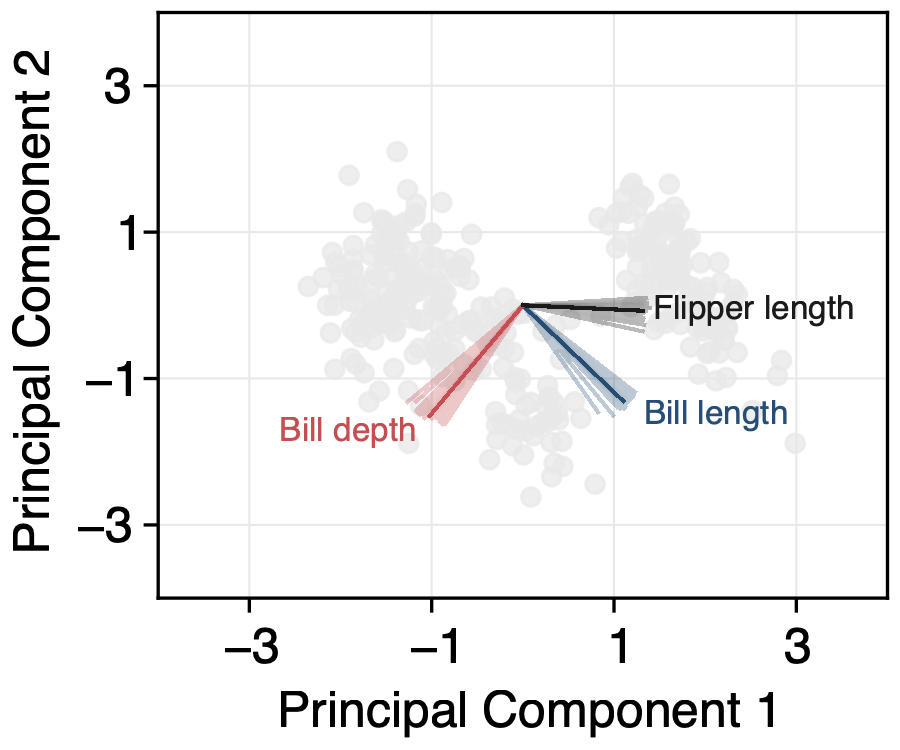

In [50]:
show_images([f'PCA_loadings.png'])

Flow visualizations appear across many fields, and one of the most recognizable examples is the Sankey diagram. By applying $bootplot$ to a Sankey diagram, we can visualize uncertainty not only in the flows but also in the underlying proportions. In our example, we again use the penguins dataset, linking species to their islands.

In [51]:
penguins_sankey = pd.DataFrame({"layer1": penguins["species"], "layer2": penguins["island"],})
species_order  = ['Adelie', 'Chinstrap', 'Gentoo']
island_order   = ['Biscoe', 'Dream', 'Torgersen'] 
species_colors = ['#FFB84D', '#B773F4', '#4DBBBB']
island_colors = ['#C0C0C0', '#C0C0C0', '#C0C0C0']
color_map = {**dict(zip(species_order, species_colors)), **dict(zip(island_order, island_colors))}

def make_sankey(data_subset, _):
    data_subset = data_subset.reset_index(drop=True)

    s = Sankey(
        data_subset,
        colorDict=color_map,
        colorMode="global",
        stripColor="left",
        layerLabels={
            "layer1": species_order,
            "layer2": island_order 
        }
    )

    fig, ax = s.plot(figSize=(6, 1.5), boxInterv=0.15, boxWidth=1, stripLen=25, stripShrink=0.8)
    fig.set_dpi(300)
    fig.set_constrained_layout(True)

    for t in list(ax.texts):
        t.remove()

    y_position = [0.12, 0.50, 0.88]
    for y, left_label, right_label in zip(y_position, species_order, island_order):
        ax.text(0, y, left_label, ha="right", va="center", transform=ax.transAxes, color="black")
        ax.text(1, y, right_label, ha="left", va="center", transform=ax.transAxes, color="black")

    img = plot_to_array(fig)
    close_figure(fig)
    return img

In [52]:
np.random.seed(15)
mat = bootplot(
    make_sankey,
    penguins_sankey,
    m=39,
    output_image_path="sankey_diagram.png",
    verbose=True,
    backend="basic"
)

Generating plots: 100%|█████████████████████████| 39/39 [00:02<00:00, 18.69it/s]


> Saving bootstrapped image to sankey_diagram.png


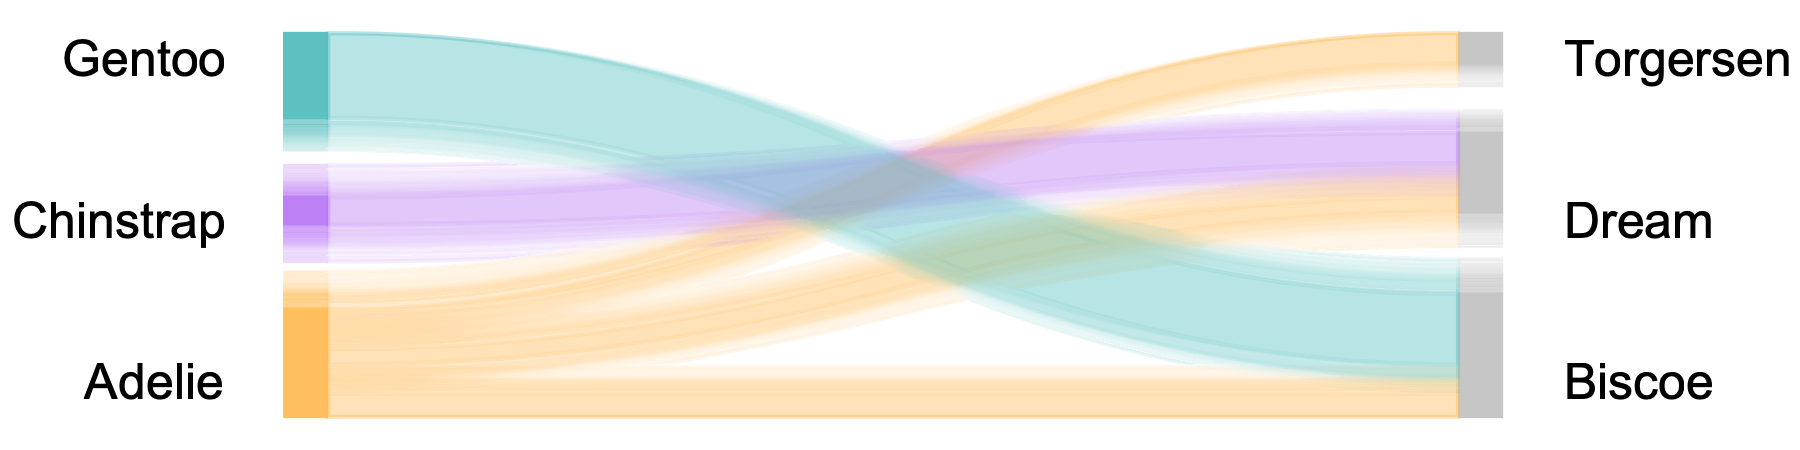

In [53]:
show_images([f'sankey_diagram.png'])

At the start of this tutorial, we applied bootplot to simple univariate parameters such as the mean, visualized with basic scatterplots. But these parameters can also be displayed with more elaborate visualizations, like radar charts (also called web charts or spider charts). Let's apply $bootplot$ to that as well.

In [54]:
species_order  = ["Adelie", "Chinstrap", "Gentoo"]
species_color = ["#FFB84D", "#B773F4", "#4DBBBB"]
cols  = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
labels = ["Bill\nLength", "Bill\nDepth", "Flipper\nLength", "Body\nMass"]

def make_radar_species(data_subset, data_full):
    means = data_subset.groupby("species")[cols].mean()
    
    k = len(cols)
    angles = np.linspace(0, 2 * np.pi, k, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    ax.set(
        theta_offset=np.pi / 2,
        theta_direction=-1,
        ylim=(0, 1),
        yticks=[0.2, 0.4, 0.6, 0.8, 1.0],
        rlabel_position=0,
        xticks=angles[:-1],
        xticklabels=labels
    )
    
    ax.tick_params(axis="x", pad=15) 
    ax.tick_params(axis="y", labelsize=8)

    for color, species in zip(species_color, means.index):
        means_species = means.loc[species].to_numpy()
        means_species = np.concatenate([means_species, [means_species[0]]])
        ax.plot(angles, means_species, linewidth=2, color=color, label=species, antialiased=False)
        ax.fill(angles, means_species, color=color, alpha=0.15)

    ax.grid(True, linewidth=0.5, color="#E8E8E8", zorder=-10000)
    ax.set_axisbelow(True)
    fig.set_constrained_layout(True)

    img = plot_to_array(fig)
    close_figure(fig)
    return img

In [55]:
X = MinMaxScaler().fit_transform(penguins[cols])
penguins_normalized = pd.DataFrame(X, columns=cols)
penguins_normalized.insert(0, "species", penguins["species"])

np.random.seed(15)
mat = bootplot(
    make_radar_species,
    penguins_normalized,
    m=39,
    output_image_path="radar_chart.png",
    verbose=True,
    backend="basic",
)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 21.67it/s]


> Saving bootstrapped image to radar_chart.png


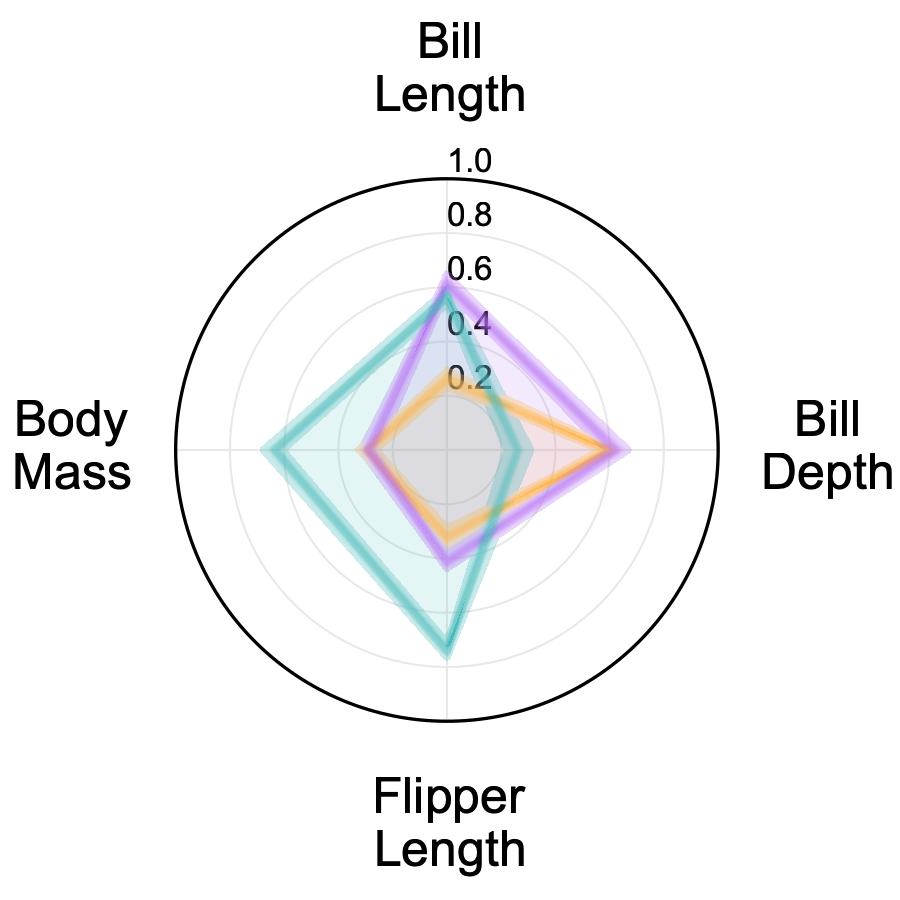

In [56]:
show_images([f'radar_chart.png'])

Earlier we treated a regression line as the parameter of interest, and we can push the idea further by using a neural network’s decision boundary as the parameter of interest as well, with $bootplot$ showing how that boundary shifts and revealing uncertainty in the categorical prediction space.

In [57]:
species_order = ["Adelie", "Chinstrap", "Gentoo"]
colors = ['#FF8C00', '#A020F0', '#008B8B']
cols = ["bill_length_mm","bill_depth_mm","species"]
cmap   = ListedColormap(colors)
levels = np.arange(-0.5, len(species_order)+0.5, 1)

def nn_decision_regions(data_subset, data_full, ax):
    for i, sp in enumerate(species_order):
        m = data_full["species"].eq(sp)
        ax.scatter(data_full.loc[m,"bill_length_mm"], data_full.loc[m,"bill_depth_mm"],
                   c=colors[i], s=20, alpha=0.5, edgecolor='grey', linewidths=0.75,
                   marker='o', label=sp, zorder=100)

    X = data_subset[["bill_length_mm","bill_depth_mm"]].to_numpy()
    y = pd.Categorical(data_subset["species"], categories=species_order).codes
    clf = make_pipeline(StandardScaler(),
                        MLPClassifier(hidden_layer_sizes=(8,8), activation="tanh",
                                      max_iter=1000, random_state=42)).fit(X, y)

    x_min, x_max = data_full["bill_length_mm"].min(), data_full["bill_length_mm"].max()
    y_min, y_max = data_full["bill_depth_mm" ].min(), data_full["bill_depth_mm" ].max()
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,400), np.linspace(y_min,y_max,400))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


    X_full = data_full[["bill_length_mm","bill_depth_mm"]].to_numpy()
    y_full = pd.Categorical(data_full["species"], categories=species_order).codes
    clf_full = make_pipeline(StandardScaler(),
                        MLPClassifier(hidden_layer_sizes=(8,8), activation="tanh",
                                      max_iter=1000, random_state=42)).fit(X_full, y_full)
    Z_full = clf_full.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    #data full
    ax.contour(xx, yy, Z_full, levels=np.arange(len(species_order)-1)+0.5,
               linewidths=1.5, colors="#264d73", zorder=10000)

    
    ax.grid(True, linewidth=0.5, color="#E8E8E8"); ax.set_axisbelow(True)
    ax.contourf(xx, yy, Z, levels=levels, cmap=cmap, alpha=0.10, antialiased=False)
    ax.contour(xx, yy, Z, levels=np.arange(len(species_order)-1)+0.5,
               linewidths=1.5, colors="#264d73", antialiased=False, zorder=10000)
               #linewidths=1, colors="black", antialiased=False, zorder=10000)
    ax.set(xlabel='Bill Length', ylabel='Bill Depth',
           xlim=(x_min, x_max), ylim=(y_min, y_max),
           xticks=np.arange(np.ceil(x_min), np.floor(x_max) + 1, 5),
           yticks=np.arange(np.ceil(y_min), np.floor(y_max) + 1, 2))
    ax.get_figure().set_constrained_layout(True)

In [58]:
np.random.seed(15)
mat = bootplot(
    nn_decision_regions,
    penguins[["bill_length_mm","bill_depth_mm","species"]],
    m=39,
    output_image_path="nn_decision_boundaries.png",
    output_size_px=(dpi*3, dpi*2.5),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:13<00:00,  2.88it/s]


> Saving bootstrapped image to nn_decision_boundaries.png


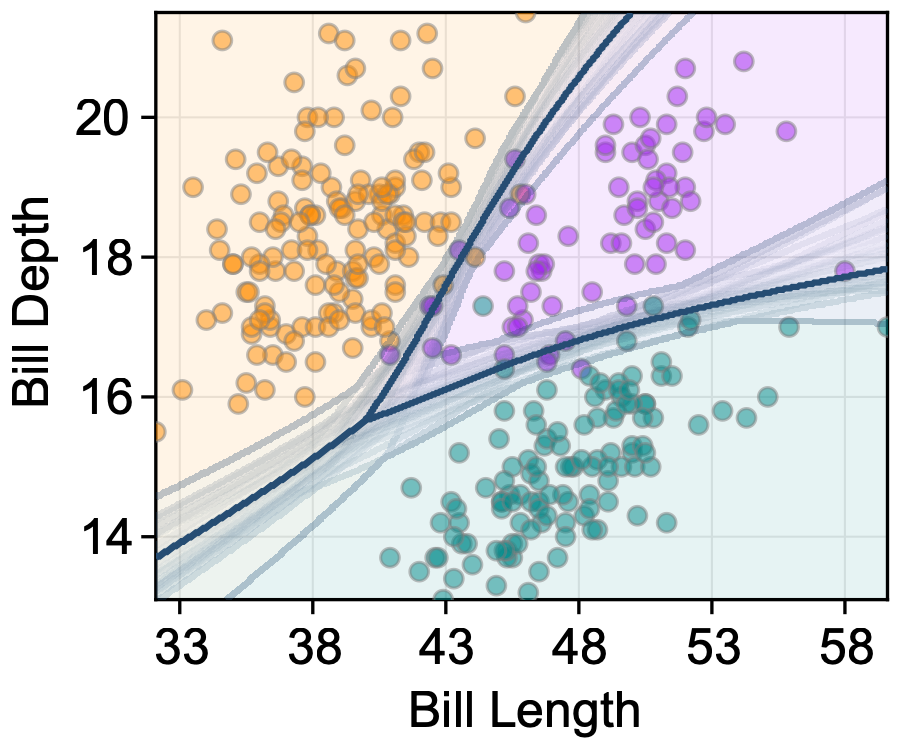

In [59]:
show_images([f'nn_decision_boundaries.png'])

Graphs offer a very interesting use-case for $bootplot$. Using the penguins dataset, we can apply $bootplot$ to a feature network where each node represents a penguin measurement and each edge’s thickness reflects the correlation between two features. Positive correlations appear in blue, while negative ones appear in red.

In [60]:
cols  = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
node_name = ["A", "B", "C", "D"]

G_ref = nx.Graph()
G_ref.add_nodes_from(cols)
position = nx.spring_layout(G_ref, seed=0)
xs, ys = np.array([p[0] for p in position.values()]), np.array([p[1] for p in position.values()])
x_lim, y_lim = (xs.min()-0.6, xs.max()+0.6), (ys.min()-0.6, ys.max()+0.6)

legend_labels = ["A-Bill length", "B-Bill depth", "C-Flipper length", "D-Body mass"]

def graph_correlation(data_subset, _data_full, ax):
    corr = data_subset[cols].corr().values

    iu = np.triu_indices_from(corr, k=1)
    # keep all pairs, store signed weights
    edges = [(cols[i], cols[j], float(corr[i, j])) for i, j in zip(*iu)]

    G = nx.Graph()
    G.add_nodes_from(cols)
    if edges:
        G.add_weighted_edges_from(edges)

    nx.draw_networkx_nodes(G, position, ax=ax, node_size=1000, node_color="#E8E8E8", edgecolors="black")
    nx.draw_networkx_labels(G, position, labels=dict(zip(cols, node_name)), ax=ax)

    if G.number_of_edges():
        edge_colors = ["#B773F4" if w > 0 else "#C0C0C0" for *_, w in G.edges(data="weight")]
        edge_widths = [12*abs(w) for *_, w in G.edges(data="weight")] 
        lc = nx.draw_networkx_edges(G, position, ax=ax, width=edge_widths, edge_color=edge_colors, alpha=1)
        if lc is not None:
            lc.set_antialiased(False)

    handles = [plt.Line2D([], [], color="none", label=lbl) for lbl in legend_labels]
    ax.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=2, handlelength=0, handletextpad=0)

    ax.set(aspect="equal", xlim=x_lim, ylim=y_lim)
    ax.axis("off")
    ax.set_position([0, 0.1, 1, 0.9])
    ax.get_figure().set_constrained_layout(True)


In [61]:
np.random.seed(15)
mat = bootplot(
    graph_correlation,
    penguins.query("species == 'Chinstrap'").iloc[:,2:6],                  
    m=39,
    output_image_path="correlation_graph.png",
    output_size_px=(dpi*3, dpi*3),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 38.48it/s]


> Saving bootstrapped image to correlation_graph.png


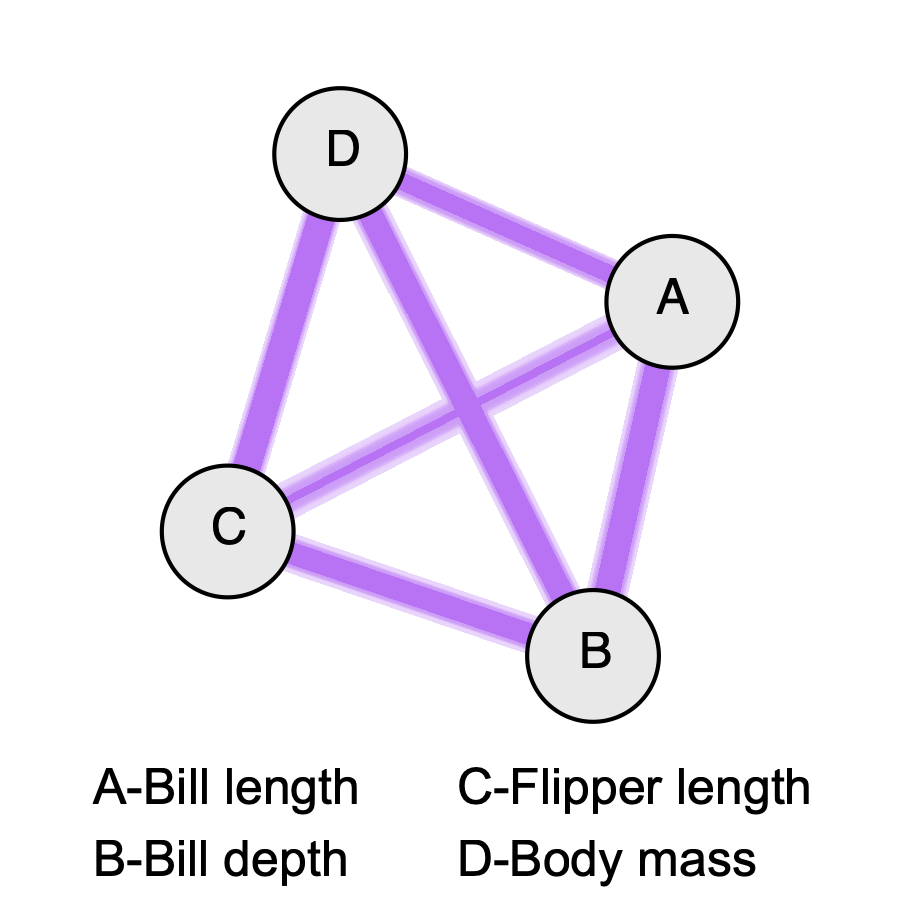

In [62]:
show_images([f'correlation_graph.png'])

Although standard density plots cannot be created meaningfully with our method, the approach is still useful when other elements in the plot are uncertain or when the density estimate itself is uncertain. In that case, instead of a single curve, the uncertain density can be shown as a mixture of shapes that reflects its variability. The resulting $bootplot$ visualization makes the uncertainty effect in the density plot immediately noticeable.

In [63]:
x_min, x_max = penguins.iloc[:, 2].min(), penguins.iloc[:, 2].max()
def density(data_subset, data_full, ax):
    bill = data_subset["bill_length_mm"]
    bill_full = data_full["bill_length_mm"]
    #bill = data_subset[data_subset["species"] == "Gentoo"]
    
    kde = gaussian_kde(bill)
    kde_full = gaussian_kde(bill_full)
    x_vals = np.linspace(x_min, x_max, 500)
    density = kde(x_vals)
    density_full = kde_full(x_vals)
    ax.plot(x_vals, density_full, alpha=1, color="#264d73", zorder=1000, antialiased=False)
    ax.fill_between(x_vals, density, alpha=1, color="#4DBBBB", zorder=100, antialiased=False)

    ax.set(
        xlabel='Bill Length', ylabel='Density',
        xlim=(x_min, x_max), ylim=(0, 0.19),
        xticks=np.arange(np.ceil(x_min), np.floor(x_max) + 1, 5)
    )

    ax.grid(True, linewidth=0.5, color="#E8E8E8"); ax.set_axisbelow(True)
    ax.grid(axis='both', linewidth=0.5, color='#E8E8E8', zorder=-5000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_figure().set_constrained_layout(True)


In [64]:
np.random.seed(15)
mat = bootplot(
    density,
    penguins[penguins["species"] == "Gentoo"],
    m=39,
    output_image_path="density.png",
    output_size_px=(dpi*3, dpi*2.5),
    verbose=True
)

Generating plots: 100%|█████████████████████████| 39/39 [00:01<00:00, 32.06it/s]


> Saving bootstrapped image to density.png


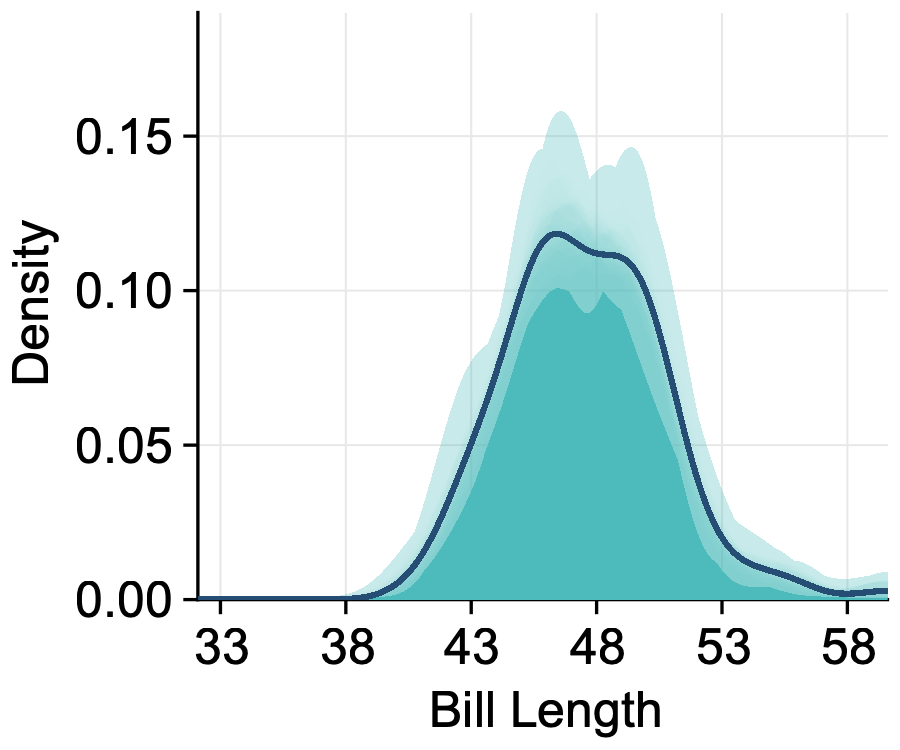

In [65]:
show_images([f'density.png'])

The final two examples are based on a simple air mass trajectories dataset. 

In [66]:
trajectory_coordinates = pd.read_csv('trajectory_coordinates.csv').dropna()

In [67]:
def trajectory_mean(data_subset, data_full, ax):
    ax.imshow(mpimg.imread("map.png"),
              extent=[-55, 20, -15, 150],
              aspect='auto', zorder=-100)
    
    for row in data_full.itertuples(index=False):
        ax.plot(row[:56], row[56:],
                color='#264d73', lw=0.7, alpha=0.25,
                ls='--', antialiased=False, zorder=50)

    for data, z in [(data_full, 100), (data_subset, 100)]:
        means = np.mean(data, axis=0)
        ax.plot(means[:56], means[56:], color='#c44e52',
                lw=1, antialiased=False, zorder=z)

    ax.set(xlim=(-55, 20), ylim=(-15, 150))
    ax.axis('off')
    ax.get_figure().set_constrained_layout(True)

In [68]:
np.random.seed(15)
mat = bootplot(
        trajectory_mean,
        trajectory_coordinates,
        m=39,
        output_image_path=f'trajectories.png',
        output_size_px=(3*dpi, 3*dpi),
        verbose=True
    )

Generating plots: 100%|█████████████████████████| 39/39 [00:07<00:00,  4.88it/s]


> Saving bootstrapped image to trajectories.png


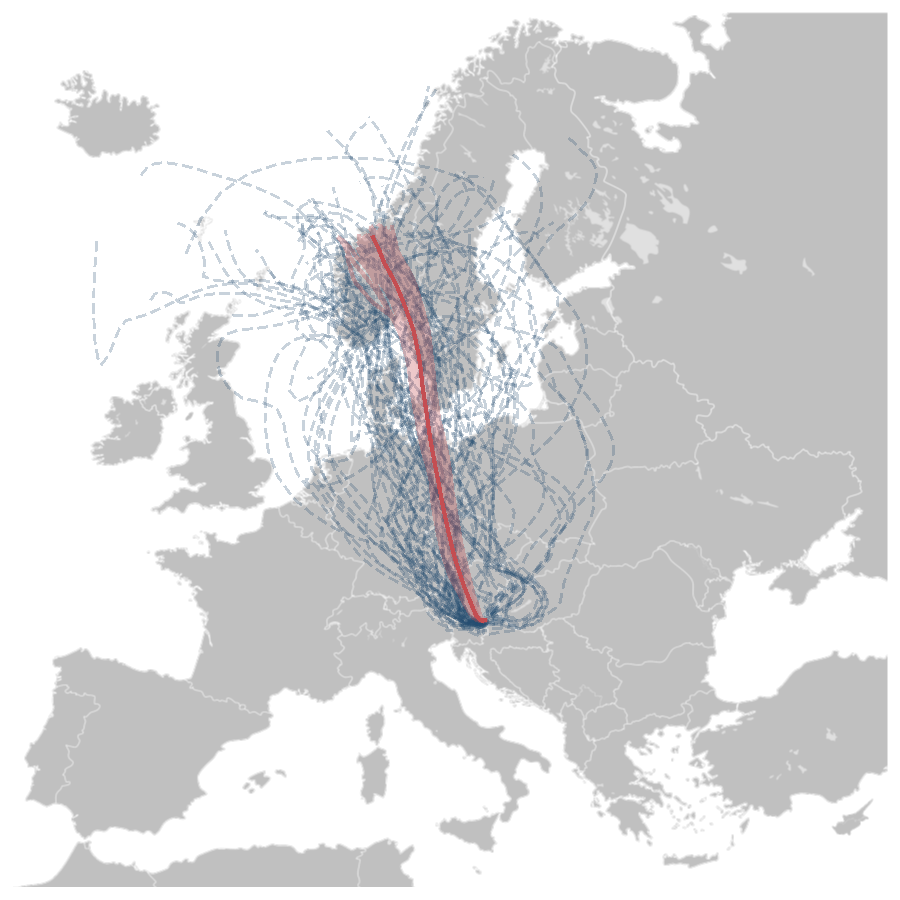

In [69]:
show_images([f'trajectories.png'])

A heatmap is a somewhat peculiar case, since it represents uncertainty via color blending or transparency, yet it performs particularly well when the variable assumes only two states.

In [70]:
def trajectory_heatmap(data_subset, data_full, ax):
    ax.imshow(mpimg.imread("map.png"),
              extent=[-55, 20, -15, 150],
              aspect='auto', zorder=-100)
    x = np.squeeze(data_subset)[:56]
    y = np.squeeze(data_subset)[56:112]
    x_min, x_max = -55, 20
    y_min, y_max = -15, 150
    n_bins = 10
    
    dx = (x_max - x_min) / n_bins
    dy = (y_max - y_min) / n_bins
    ix = np.floor((x - x_min) / dx).astype(int)
    iy = np.floor((y - y_min) / dy).astype(int)

    visited = np.zeros((n_bins, n_bins), dtype=bool)
    visited[iy, ix] = True

    for j in range(n_bins):
        for i in range(n_bins):
            if visited[j, i]:
                ax.add_patch(Rectangle(
                    (x_min + i * dx, y_min + j * dy),
                    dx, dy,
                    facecolor="#264d73", alpha=1, antialiased=False
                    #facecolor="black", alpha=1, antialiased=False
                ))
    
    # transparent to blue
    from matplotlib import cm, colors
    from matplotlib.colors import LinearSegmentedColormap
    
    # position inside axis
    cax = ax.inset_axes([0.15, 0.1, 0.7, 0.03])
    cax.set_facecolor("none")
    
    cmap = LinearSegmentedColormap.from_list(
        "random_cm",
        [
            (0.0, (38/255, 77/255, 115/255, 0.0)),   # transparent black
            (0.5, (38/255, 77/255, 115/255, 0.5)),   # half transparent
            (1.0, (38/255, 77/255, 115/255, 1.0)),   # fully opaque
        ]
    )

    norm = colors.Normalize(0, 1)
    
    cb = ax.figure.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation="horizontal",
    )
    
    cb.set_ticks([0, 0.5, 1])
    cb.set_ticklabels(["0%", "50%", "100%"])


    ax.set(xlim=(-55, 20), ylim=(-15, 150), xticks=[], yticks=[])
    ax.axis("off")
    ax.get_figure().set_constrained_layout(True)


In [71]:
np.random.seed(15)
mat = bootplot(
        trajectory_heatmap,
        trajectory_coordinates,
        m=39,
        output_image_path=f'trajectories_heatmap.png',
        output_size_px=(3*dpi, 3*dpi),
        single_sample = True,
        verbose=True
    )

Generating plots: 100%|█████████████████████████| 39/39 [00:07<00:00,  4.91it/s]


> Saving bootstrapped image to trajectories_heatmap.png


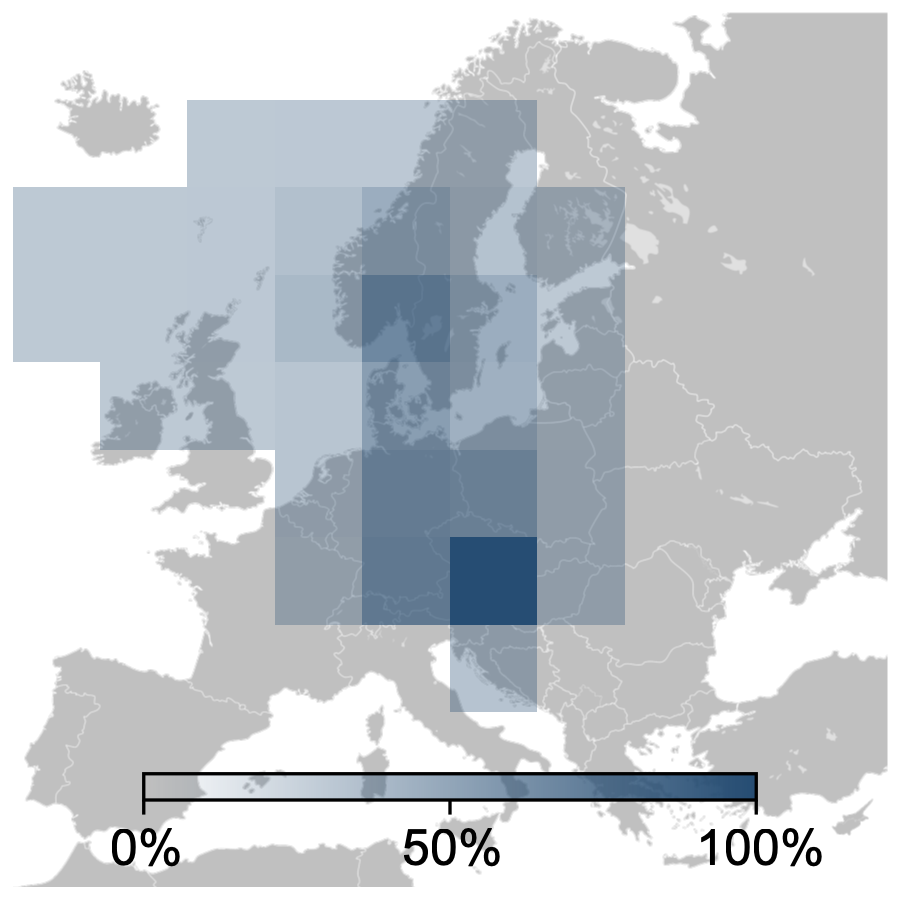

In [72]:
show_images([f'trajectories_heatmap.png'])

The examples above are included in our paper, but $bootplot$ can be used with many other types of statistical graphics as well.
In every case, the idea is the same: you just visualize the quantity of interest. The uncertainty, whether shown as intervals, bands, regions, or gradients, emerges automatically through the aggregation of the visualized distribution.

We hope you found this short tutorial helpful. If you have any questions or feedback, feel free to reach out to us at bernarda.petek@fri.uni-lj.si.